---

Program ini dibuat untuk melakukan customer segmentation menggunakan model clustering dari data kartu kredit perbankan selama 6 bulan terakhir yang diperoleh dari google bigquery. Selanjutnya data hasil clustering customer dianalisa untuk menghasilkan insight dan rekomendasi bisnis ke setiap cluster dengan tepat.

---

# Query SQL

In [1]:
# from google.oauth2 import service_account

# # Use a raw string (prefix with 'r') to avoid escape character issues
# SERVICE_ACCOUNT_FILE_PATH = r"C:\Users\asus\Documents\iyan nitip\json\supple-gearbox-432504-c7-857effb9baf3.json"

# # Specify the desired scopes (e.g., Gmail readonly)
# SCOPES = ['https://www.googleapis.com/auth/bigquery']

# # Create credentials from the service account file
# credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE_PATH, scopes=SCOPES)

# from google.cloud import bigquery

# # Initialize the client
# client = bigquery.Client(credentials=credentials,
#                          project=credentials.project_id,
#                          default_query_job_config=bigquery.QueryJobConfig(default_dataset='ftds-hacktiv8-project.practice'))

In [2]:
# df =client.query ('''
# SELECT *
# FROM `ftds-hacktiv8-project.phase1_ftds_021_hck.credit-card-information`
# WHERE MOD(CAST(CUST_ID AS INT64), 2) = 1;

#   ''').to_dataframe()
# df

In [3]:
# # export to csv
# df.to_csv('P1G6_Set_1_Zamzani.csv', index=False)

# Problem Statement
Membuat Customer Segmentation berdasarkan data penggunaan kartu kredit selama 6 bulan terakhir dengan menggunakan metode machine learning unsupervised **`clustering`** . Tujuan dari analisis ini adalah untuk mengelompokkan nasabah ke dalam segmen-segmen berbeda berdasarkan perilaku penggunaan kartu kredit mereka, sehingga tim pemasaran dapat merancang strategi yang lebih tepat sasaran untuk setiap kelompok yang akan membantu meningkatkan retensi nasabah dan memaksimalkan penggunaan kartu kredit.

# Import Libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

from scipy.stats import skew
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pickle
import json


# Data Loading 

## Import CSV file

In [5]:
data = pd.read_csv('customer_data.csv')

## Data Dictionary

| Column Name | Data Type | Description |
|---|---|---|
| CUST_ID | INT64 | Identification of Credit Card holder |
| BALANCE | FLOAT64 | Balance amount left in their account to make purchases |
| BALANCE_FREQUENCY | FLOAT64 | How frequently the Balance is updated, score between 0 and 1 (1 frequently updated, 0 not frequently updated) |
| PURCHASES | FLOAT64 | Amount of purchases made from account |
| ONEOFF_PURCHASES | FLOAT64 | Maximum purchase amount done in one-go |
| INSTALLMENTS_PURCHASES | FLOAT64 | Amount of purchase done in installment |
| CASH_ADVANCE | FLOAT64 | Cash in advance given by the user |
| PURCHASES_FREQUENCY | FLOAT64 | How frequently the Purchases are being made, score between 0 and 1 (1 frequently purchased, 0 not frequently purchased) |
| ONEOFF_PURCHASES_FREQUENCY | FLOAT64 | How frequently Purchases are happening in one-go (1 frequently purchased, 0 = not frequently purchased) |
| PURCHASES_INSTALLMENTS_FREQUENCY | FLOAT64 | How frequently purchases in installments are being done (1 frequently done, 0 not frequently done) |
| CASH_ADVANCE_FREQUENCY | FLOAT64 | How frequently the cash in advance being paid |
| CASH_ADVANCE_TRX | INT64 | Number of Transactions made with 'Cash in Advanced' |
| PURCHASES_TRX | INT64 | Number of purchase transactions made |
| CREDIT_LIMIT | FLOAT64 | Limit of Credit Card for user |
| PAYMENTS | FLOAT64 | Amount of Payment done by user |
| MINIMUM_PAYMENTS | FLOAT64 | Minimum amount of payments made by user |
| PRC_FULL_PAYMENT | FLOAT64 | Percent of full payment paid by user |
| TENURE | INT64 | Tenure of credit card service for user |


## 10 first rows

In [6]:
data.head(10)

CUST_ID     BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     3091    3.833185           0.125000      45.00             45.00   
1     5069    0.000000           0.000000     176.03            176.03   
2     6075  757.964752           0.875000     157.40            157.40   
3     6291  264.566591           0.375000    1150.00           1150.00   
4     7755  440.613643           1.000000     600.00            600.00   
5     8299  611.561026           1.000000     765.00            765.00   
6     8629    0.228572           0.125000      60.00             60.00   
7     8805  105.333584           0.375000     306.00            306.00   
8        7   16.379412           0.454545     178.15              0.00   
9       91  559.151424           1.000000      94.00             94.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    0.00           0.0                0.125   
1                    0.00           0.0                0.125   
2                    0.00           0.0                0.125   
3                    0.00           0.0                0.125   
4                    0.00           0.0                0.125   
5                    0.00           0.0                0.125   
6                    0.00           0.0                0.125   
7                    0.00           0.0                0.125   
8                  178.15           0.0                0.250   
9                    0.00           0.0                0.250   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125                              0.00   
1                       0.125                              0.00   
2                       0.125                              0.00   
3                       0.125                              0.00   
4                       0.125                              0.00   
5                       0.125                              0.00   
6                       0.125                              0.00   
7                       0.125                              0.00   
8                       0.000                              0.25   
9                       0.250                              0.00   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              1         500.0   
1                     0.0                 0              1        7000.0   
2                     0.0                 0              6        1200.0   
3                     0.0                 0              1        1200.0   
4                     0.0                 0              1        1000.0   
5                     0.0                 0              1        2000.0   
6                     0.0                 0              1        1500.0   
7                     0.0                 0              2        6000.0   
8                     0.0                 0              3        5000.0   
9                     0.0                 0              3        5500.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0     0.000000               NaN          0.000000       8  
1     0.000000               NaN          0.000000       8  
2  1494.480376       2638.598410          0.000000       8  
3  3029.380326         85.428885          0.000000       8  
4   215.316424        137.846006          0.000000       8  
5   204.464151        146.352314          0.000000       8  
6   438.738982               NaN          0.000000       8  
7   101.986927        118.324082          0.000000       8  
8   229.376368         89.613822          0.181818      12  
9   254.733329        218.279194          0.000000      12

## 10 last rows

In [7]:
data.tail(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
4465     6809  4438.521324           1.000000     591.84            109.16   
4466     7211  1135.703750           1.000000      92.07              0.00   
4467     8295   185.984965           0.454545     482.24            392.24   
4468     8855  3531.167073           0.900000     797.50            577.83   
4469     2389  1917.895730           1.000000     285.07            285.07   
4470     2345  9629.808851           1.000000       0.00              0.00   
4471     6785  1040.030221           1.000000       0.00              0.00   
4472     7347  1322.818587           1.000000       0.00              0.00   
4473     8447  1060.391273           1.000000       0.00              0.00   
4474     1995  3447.674222           1.000000     205.00            205.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4465                  482.68    564.365429             0.636364   
4466                   92.07     81.509491             0.272727   
4467                   90.00    903.843591             0.272727   
4468                  219.67   5273.226918             0.700000   
4469                    0.00   6084.858872             0.363636   
4470                    0.00   4372.393835             0.000000   
4471                    0.00   1390.648290             0.000000   
4472                    0.00    762.301096             0.000000   
4473                    0.00   1475.858013             0.000000   
4474                    0.00   4548.057776             0.090909   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4465                    0.181818                          0.454545   
4466                    0.000000                          0.181818   
4467                    0.181818                          0.090909   
4468                    0.400000                          0.500000   
4469                    0.363636                          0.000000   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.000000                          0.000000   
4473                    0.000000                          0.000000   
4474                    0.090909                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4465                0.272727                 3             11       17000.0   
4466                0.272727                 3              3        1200.0   
4467                0.272727                 8              8        1200.0   
4468                0.900000                33             21        4000.0   
4469                1.090909                28              6        3000.0   
4470                0.545455                 9              0       12000.0   
4471                0.545455                18              0        1400.0   
4472                0.545455                11              0        1500.0   
4473                0.545455                10              0        2000.0   
4474                0.545455                 7              1       10500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4465  5552.601399       1094.486286              0.00      11  
4466   355.798199        434.689529              0.00      11  
4467  2333.997439        160.900585              0.25      11  
4468  2979.546700       3052.080103              0.00      10  
4469  5692.682993        556.449635              0.00      11  
4470  2468.988022       2134.295731              0.00      11  
4471   290.129620        287.994171              0.00      11  
4472  1035.627320        312.835530              0.00      11  
4473   407.360560        277.084736              0.00      11  
4474   665.239171        817.844662              0.00      11

# Exploratory Data Analyis

In [8]:
# create duplicate 
data_eda = data.copy()
data_eda

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0        3091     3.833185              0.125      45.00             45.00   
1        5069     0.000000              0.000     176.03            176.03   
2        6075   757.964752              0.875     157.40            157.40   
3        6291   264.566591              0.375    1150.00           1150.00   
4        7755   440.613643              1.000     600.00            600.00   
...       ...          ...                ...        ...               ...   
4470     2345  9629.808851              1.000       0.00              0.00   
4471     6785  1040.030221              1.000       0.00              0.00   
4472     7347  1322.818587              1.000       0.00              0.00   
4473     8447  1060.391273              1.000       0.00              0.00   
4474     1995  3447.674222              1.000     205.00            205.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                        0.0      0.000000             0.125000   
1                        0.0      0.000000             0.125000   
2                        0.0      0.000000             0.125000   
3                        0.0      0.000000             0.125000   
4                        0.0      0.000000             0.125000   
...                      ...           ...                  ...   
4470                     0.0   4372.393835             0.000000   
4471                     0.0   1390.648290             0.000000   
4472                     0.0    762.301096             0.000000   
4473                     0.0   1475.858013             0.000000   
4474                     0.0   4548.057776             0.090909   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125000                               0.0   
1                       0.125000                               0.0   
2                       0.125000                               0.0   
3                       0.125000                               0.0   
4                       0.125000                               0.0   
...                          ...                               ...   
4470                    0.000000                               0.0   
4471                    0.000000                               0.0   
4472                    0.000000                               0.0   
4473                    0.000000                               0.0   
4474                    0.090909                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              1         500.0   
1                   0.000000                 0              1        7000.0   
2                   0.000000                 0              6        1200.0   
3                   0.000000                 0              1        1200.0   
4                   0.000000                 0              1        1000.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0       12000.0   
4471                0.545455                18              0        1400.0   
4472                0.545455                11              0        1500.0   
4473                0.545455                10              0        2000.0   
4474                0.545455                 7              1       10500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0        0.000000               NaN               0.0       8  
1        0.000000               NaN               0.0       8  
2     1494.480376       2638.598410               0.0       8  
3     3029.380326         85.428885               0.0       8  
4      215.316424        137.846006               0.0       8  
...           ...               ...               ...     ...  
4470  2468.988022       21

## Check Data info 

In [9]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

Dari Infomasi diatas, diketahui : 
- Dataset terdiri dari 4475 data dan 18 kolom 
- Terdapat Missing value pada kolom `MINIMUM PAYMENTS`
- Keseluruhan kolom bertipe **Numerikal** tidak ada yang bertipe **Kategorikal** / **object** 

## Check duplicate

In [10]:
data_eda.duplicated().sum()

0

Dari informasi diatas diketahui, Tidak terdapat data duplikat pada dataset tersebut

## Check Missing value 

In [11]:
data_eda.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Dari Informasi diatas diketahui :
- Pada kolom `MINIMUM_PAYMENT`terdapat sebanyak `155` **missing value** yang nantinya harus dilakukan handling 
- missing value pada `MINIMUM_PAYMENTS` kemungkinan besar adalah MCAR (Missing Completely at Random) hal ini bisa disebabkan oleh kesalahan sistem yang tidak update atau saat input data.

In [12]:
data_eda.describe()

CUST_ID       BALANCE  BALANCE_FREQUENCY     PURCHASES  \
count  4475.000000   4475.000000        4475.000000   4475.000000   
mean   4475.000000   1563.205717           0.876933   1003.251343   
std    2583.931114   2072.045789           0.238222   2060.034730   
min       1.000000      0.000000           0.000000      0.000000   
25%    2238.000000    124.432849           0.888889     39.560000   
50%    4475.000000    871.355430           1.000000    360.000000   
75%    6712.000000   2047.570799           1.000000   1102.420000   
max    8949.000000  18495.558550           1.000000  41050.400000   

       ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
count       4475.000000             4475.000000   4475.000000   
mean         596.369893              407.110215    984.288554   
std         1653.425984              880.799744   2060.448056   
min            0.000000                0.000000      0.000000   
25%            0.000000                0.000000      0.000000   
50%           45.650000               88.620000      0.000000   
75%          575.220000              455.885000   1138.887754   
max        40624.060000            14686.100000  47137.211760   

       PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
count          4475.000000                 4475.000000   
mean              0.490579                    0.202301   
std               0.402907                    0.298203   
min               0.000000                    0.000000   
25%               0.083333                    0.000000   
50%               0.500000                    0.083333   
75%               0.916667                    0.250000   
max               1.000000                    1.000000   

       PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
count                       4475.000000             4475.000000   
mean                           0.363886                0.136132   
std                            0.397603                0.201036   
min                            0.000000                0.000000   
25%                            0.000000                0.000000   
50%                            0.166667                0.000000   
75%                            0.750000                0.250000   
max                            1.000000                1.500000   

       CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT      PAYMENTS  \
count       4475.000000    4475.000000   4475.000000   4475.000000   
mean           3.301229      14.929162   4494.878630   1740.075430   
std            7.134727      25.540814   3609.267706   2827.633858   
min            0.000000       0.000000     50.000000      0.000000   
25%            0.000000       1.000000   1600.000000    376.913051   
50%            0.000000       7.000000   3000.000000    877.494612   
75%            4.000000      17.000000   6500.000000   1911.596530   
max          123.000000     347.000000  30000.000000  50721.483360   

       MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count       4320.000000       4475.000000  4475.000000  
mean         873.976757          0.150224    11.518212  
std         2436.877272          0.289081     1.328925  
min            0.019163          0.000000     6.000000  
25%          168.590144          0.000000    12.000000  
50%          313.980229          0.000000    12.000000  
75%          819.371080          0.125000    12.000000  
max        76406.207520          1.000000    12.000000

Dari hasil cek diatas,diketahui : 
- Rata-rata `BALANCE` adalah 1563.205717, nilai ini cukup tinggi,yang berarti kebanyakan pelanggan memiliki saldo yang cukup besar.
- Rata-rata `BALANCE_FREQUENCY` cukup tinggi, menandakan bahwa pelanggan cukup aktif dalam menggunakan kartu kredit mereka.

In [13]:
data_eda.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [14]:
num_cols = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']
cat_cols = ['TENURE']

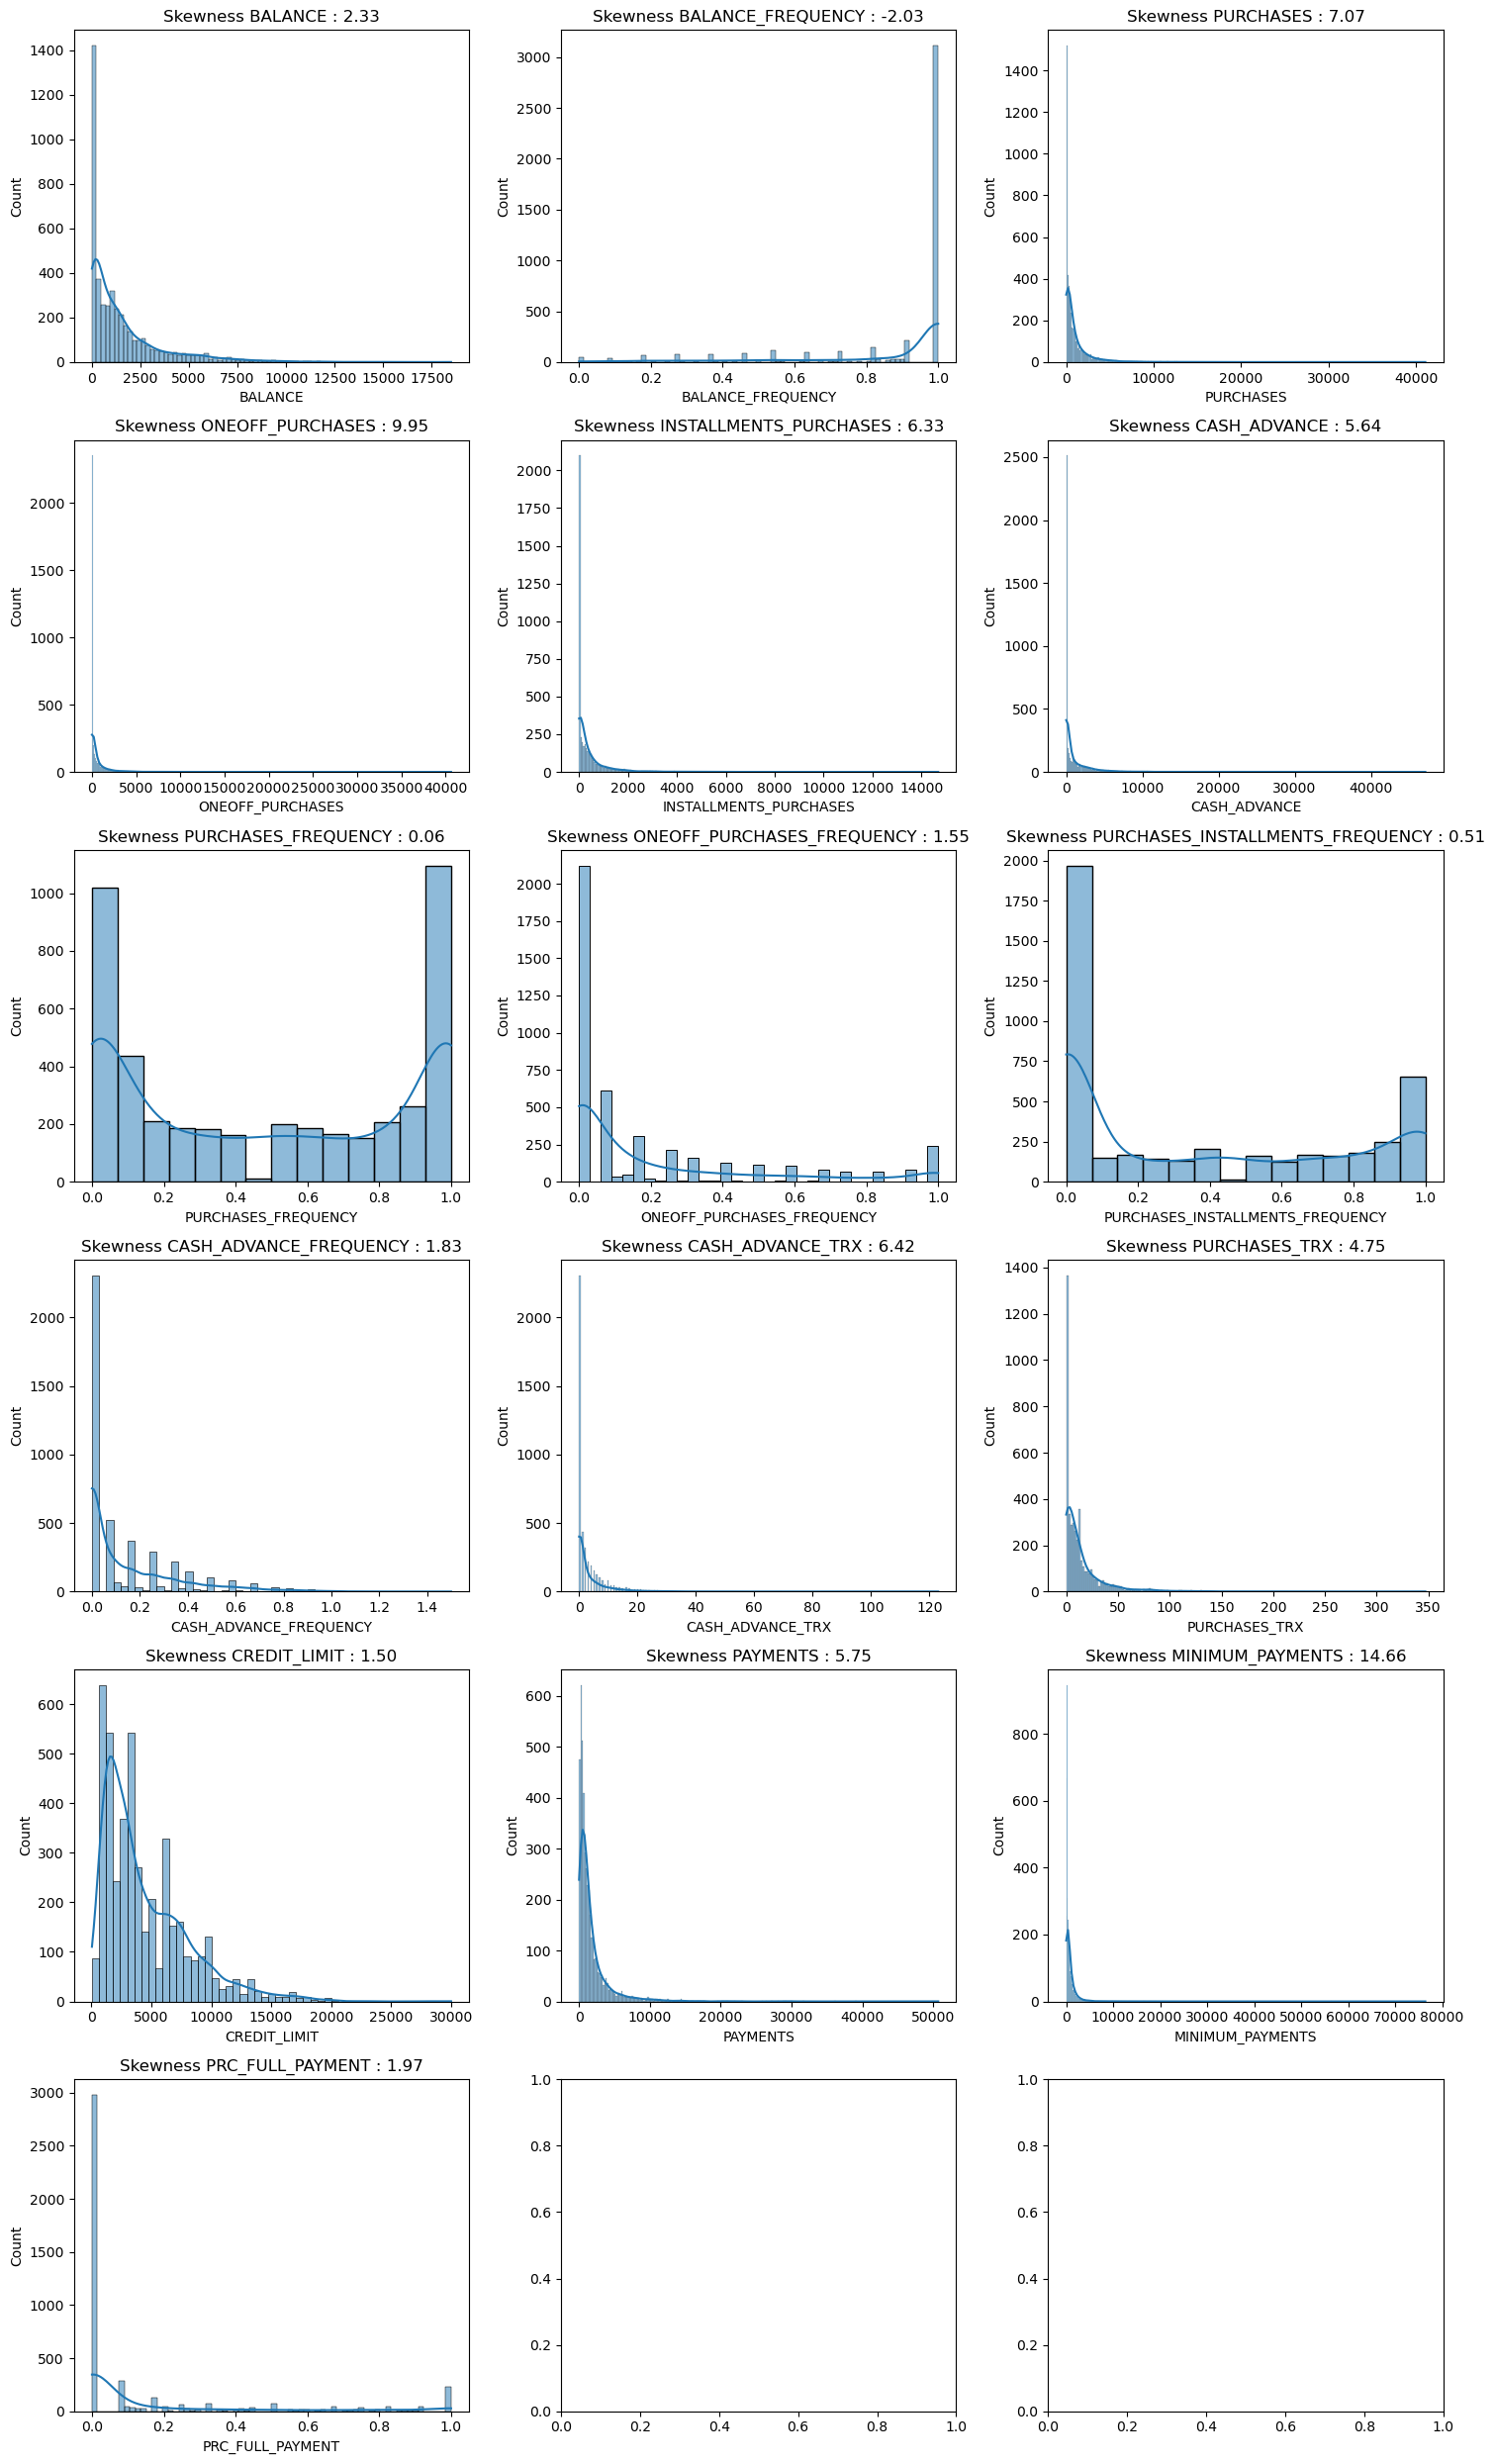

In [15]:
# Membuat grid subplot
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 25))
axes = axes.flatten()  # Meratakan array axes menjadi list

# Looping untuk mengecek skewness dan membuat histogram
for i, col in enumerate(num_cols):
    skewness_value = skew(data_eda[col].dropna())  # Mengabaikan missing values
    sns.histplot(data_eda[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Skewness {col} : {skewness_value:.2f}')

plt.tight_layout()
plt.show()


Dari visualisasi diatas, terlihat bahwa : 
- Hampir semua kolom terdistribusi secara tidak normal / skewed. 
- Kolom yang terdistribusi secara normal hanyalah kolom `PURCHACES_FREQUENCY`

## Question 1 
Apakah terdapat pola antara pengaruh `TENURE` dengan variabel `PURCHASES`, `BALANCE`, dan `PAYMENTS` ? *Buatlah visualisasi yang menunjukkan hubungan ini berikan rekomendasi bisnis untuk tim marketing mengenai hal ini.*

#### Cek Korelasi

In [16]:

# Mengambil kolom 'TENURE', 'PURCHASES', 'BALANCE', dan 'PAYMENTS'
corr_df = data_eda[['TENURE', 'PURCHASES', 'BALANCE', 'PAYMENTS']]


# Function untuk menghitung korelasi antar kolom numerikal dengan Kendall
def calculate_spearman_correlation(data_eda):
    results = []
    for col1 in data_eda.columns:
        for col2 in data_eda.columns:
            if col1 != col2:  # Menghindari membandingkan kolom yang sama
                corr_value, p_value = spearmanr(data_eda[col1], data_eda[col2])
                results.append({
                    'Korelasi': 'Spearman',
                    'Kolom 1': col1,
                    'Kolom 2': col2,
                    'Nilai Korelasi': corr_value,
                    'P-Value': p_value
                })
    # Mengubah hasil ke dalam dataframe
    return pd.DataFrame(results)

# Menghitung korelasi dengan Kendall
results_df = calculate_spearman_correlation(corr_df)

# Tampilkan hasil sebagai dataframe
results_df

Korelasi    Kolom 1    Kolom 2  Nilai Korelasi        P-Value
0   Spearman     TENURE  PURCHASES        0.126401   2.114304e-17
1   Spearman     TENURE    BALANCE        0.061795   3.525329e-05
2   Spearman     TENURE   PAYMENTS        0.198596   4.920416e-41
3   Spearman  PURCHASES     TENURE        0.126401   2.114304e-17
4   Spearman  PURCHASES    BALANCE        0.005338   7.211029e-01
5   Spearman  PURCHASES   PAYMENTS        0.392176  1.877720e-164
6   Spearman    BALANCE     TENURE        0.061795   3.525329e-05
7   Spearman    BALANCE  PURCHASES        0.005338   7.211029e-01
8   Spearman    BALANCE   PAYMENTS        0.450907  4.439808e-223
9   Spearman   PAYMENTS     TENURE        0.198596   4.920416e-41
10  Spearman   PAYMENTS  PURCHASES        0.392176  1.877720e-164
11  Spearman   PAYMENTS    BALANCE        0.450907  4.439808e-223

#### Visualisasi 

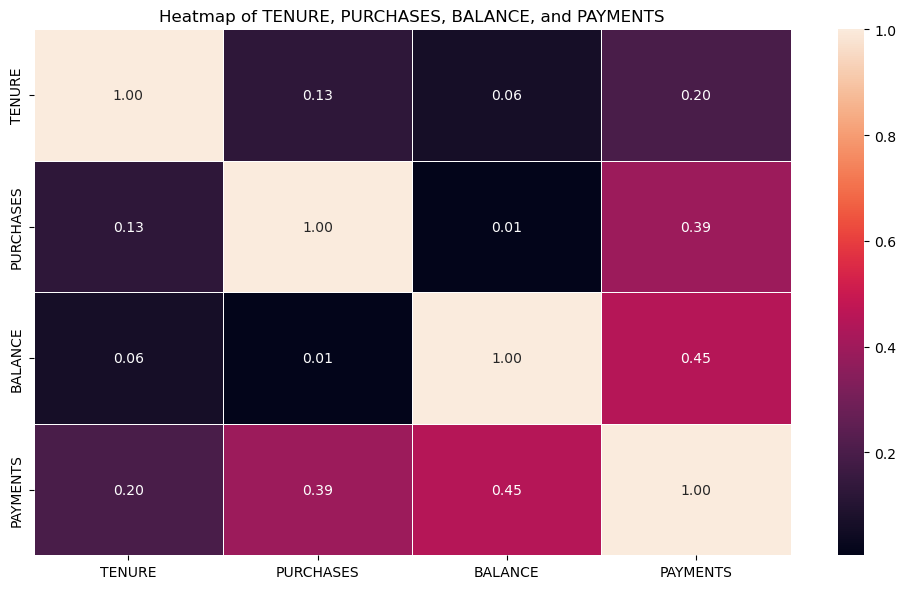

In [17]:

# Menggabungkan data yang diperlukan ke dalam satu DataFrame
heatmap_data = data_eda[['TENURE', 'PURCHASES', 'BALANCE', 'PAYMENTS']]

# Membuat figure
plt.figure(figsize=(10, 6))

# Menghitung korelasi antar variabel
correlation_matrix = heatmap_data.corr(method='spearman')

# Membuat heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)

# Menambahkan judul
plt.title('Heatmap of TENURE, PURCHASES, BALANCE, and PAYMENTS')

# Tampilkan plot
plt.tight_layout()
plt.show()


Dari visualisasi diatas diketahui : 
- **Hubungan Positif yang Kuat antara kolom PURCHASES dan PAYMENTS**
 Berarti semakin banyak seseorang melakukan pembelian, maka semakin besar jumlah pembayaran yang harus dilakukan.

**Hubungan yang Lemah**
- TENURE dan PURCHASES, Ini menunjukkan bahwa semakin lama menjadi anggota tidak berarti semakin banyak jumlah pembelian yang dilakukan.
- TENURE dan BALANCE, yang berarti semakin lama menjadi anggota tidak berarti semakin banyak saldo yang dimiliki.
- PURCHASES dan BALANCE, Ini mungkin karena faktor-faktor lain yang mempengaruhi saldo, seperti pembayaran minimum atau bunga.

**Kesimpulan** : 
<br>
Jika dilihat dari korelasinya, `tenure` terhadap variabel `purchases`, `balance` dan `payments` menunjukkan hubungan yang lemah. Artinya, variabel - variabel tersebut tidak terlalu berpengaruh terhadap `tenure`.

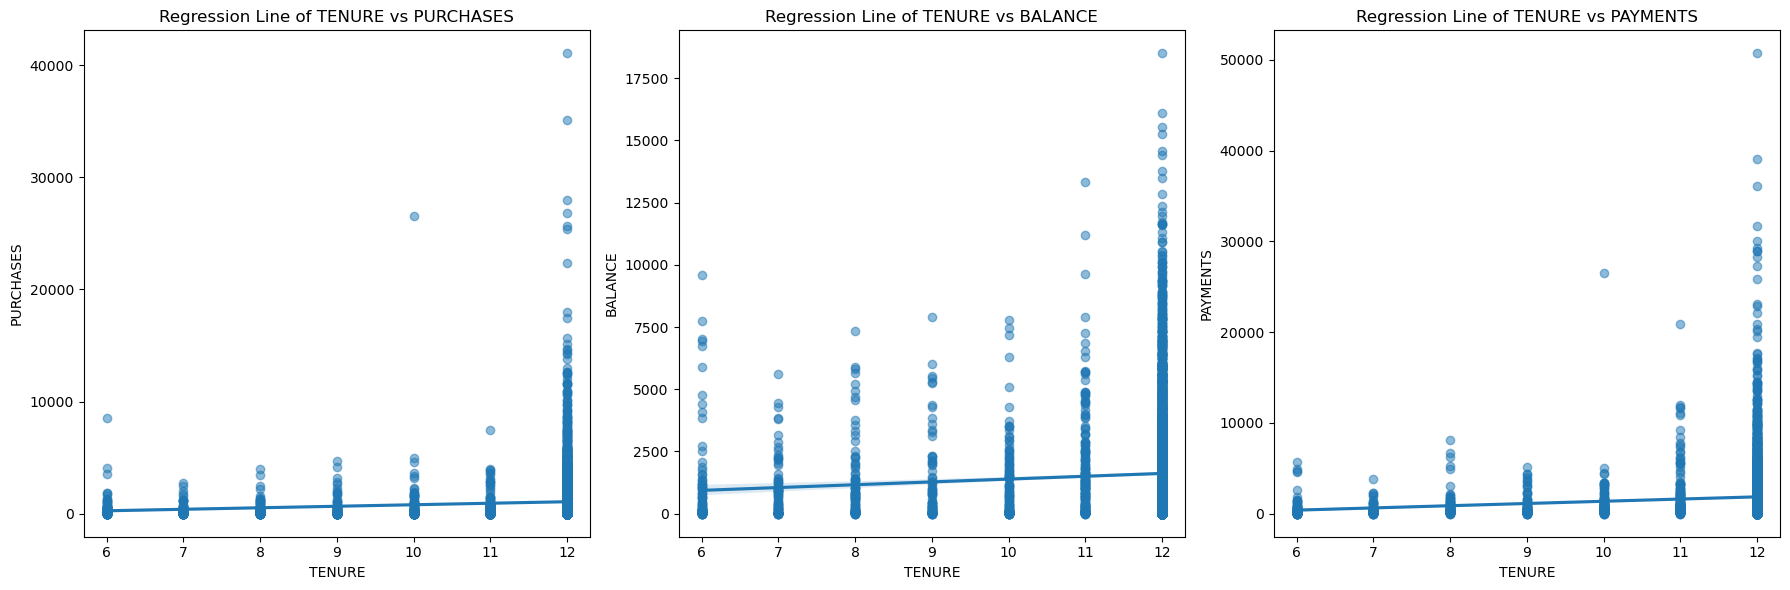

In [18]:
# Membuat figure
plt.figure(figsize=(18, 6))

# Regression line plot untuk PURCHASES
plt.subplot(1, 3, 1)
sns.regplot(x='TENURE', y='PURCHASES', data=data_eda, scatter_kws={'alpha':0.5})
plt.title('Regression Line of TENURE vs PURCHASES')

# Regression line plot untuk BALANCE
plt.subplot(1, 3, 2)
sns.regplot(x='TENURE', y='BALANCE', data=data_eda, scatter_kws={'alpha':0.5})
plt.title('Regression Line of TENURE vs BALANCE')

# Regression line plot untuk PAYMENTS
plt.subplot(1, 3, 3)
sns.regplot(x='TENURE', y='PAYMENTS', data=data_eda, scatter_kws={'alpha':0.5})
plt.title('Regression Line of TENURE vs PAYMENTS')

# Tampilkan plot
plt.tight_layout()
plt.show()


Dari Visualisasi Scater plot diatas,dapat diketahui : 
- **Tenure vs Purchases**   
 Ada sedikit peningkatan pembelian seiring bertambahnya lama pelanggan, tapi trennya cukup datar. Ini mengindikasikan bahwa lama menjadi pelanggan bukan faktor utama yang memengaruhi jumlah pembelian; mungkin faktor lain seperti promosi atau preferensi lebih berpengaruh.

- **Tenure vs Balance**   
 Saldo cenderung meningkat dengan bertambahnya lama pelanggan. Ini menunjukkan pelanggan yang sudah lama cenderung memiliki saldo lebih tinggi, mungkin karena peningkatan limit kredit atau kebiasaan menunda pembayaran.

- **Tenure vs Payments**   
 Pembayaran meningkat seiring lama menjadi pelanggan. Ini menunjukkan pelanggan lama cenderung membayar lebih banyak, mungkin karena meningkatnya pembelian atau program loyalitas.

**Noted:**
>Garis biru pada setiap grafik mewakili garis regresi linier sederhana, yang mencoba untuk menggambarkan hubungan linear antara kedua variabel.

**Rekomendasi Bisnis :**

- Manajemen Risiko Pelanggan 
> Pelanggan dengan saldo tinggi dan frekuensi pembayaran tinggi mungkin merupakan pelanggan yang lebih baik dan lebih stabil. Perusahaan dapat memberikan penawaran khusus untuk mempertahankan pelanggan seperti ini.

- Fokus pada Program Loyalitas:

>Tim marketing mungkin perlu mengembangkan program loyalitas yang mendorong pelanggan lama untuk lebih aktif dalam pembelian. Penawaran khusus seperti diskon eksklusif untuk pelanggan dengan TENURE tinggi bisa menjadi solusi untuk meningkatkan pembelian.

## Question 2
Apakah nasabah dengan CREDIT_LIMIT yang tinggi cenderung lebih sering melakukan pembelian ? Lakukanlah analisis untuk mengetahui bagaimana CREDIT_LIMIT mempengaruhi frekuensi pembelian (PURCHASES_FREQUENCY). Buatlah visualisasi yang menunjukkan hubungan ini berikan rekomendasi bisnis untuk tim marketing mengenai hal ini.

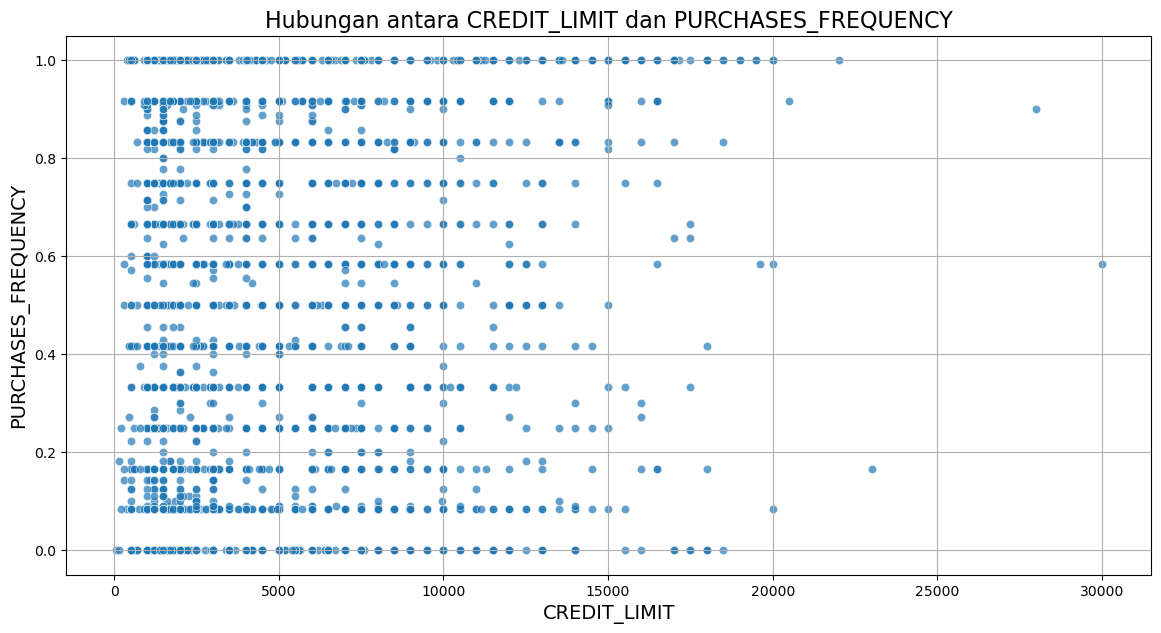

In [19]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=data_eda, x='CREDIT_LIMIT', y='PURCHASES_FREQUENCY', alpha=0.7)
plt.title('Hubungan antara CREDIT_LIMIT dan PURCHASES_FREQUENCY', fontsize=16)
plt.xlabel('CREDIT_LIMIT', fontsize=14)
plt.ylabel('PURCHASES_FREQUENCY', fontsize=14)
plt.grid()
plt.show()


**Insight:**

- Data tersebar cukup merata di seluruh rentang CREDIT_LIMIT, yang menunjukkan bahwa pelanggan dengan batas kredit tinggi dan rendah memiliki frekuensi pembelian yang tinggi dan rendah.

- Ada beberapa titik data terpisah dari kelompok data lainnya (outlier). Di titik-titik ini, pelanggan memiliki batas kredit tinggi tetapi tidak banyak membeli, atau sebaliknya.

- Tidak ada hubungan yang jelas antara CREDIT_LIMIT dan PURCHASES_FREQUENCY. Artinya, batas kredit yang tinggi tidak secara otomatis berarti seseorang akan berbelanja lebih sering.

# Feature Engineering

In [20]:
data_fe = data.copy()
data_fe

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0        3091     3.833185              0.125      45.00             45.00   
1        5069     0.000000              0.000     176.03            176.03   
2        6075   757.964752              0.875     157.40            157.40   
3        6291   264.566591              0.375    1150.00           1150.00   
4        7755   440.613643              1.000     600.00            600.00   
...       ...          ...                ...        ...               ...   
4470     2345  9629.808851              1.000       0.00              0.00   
4471     6785  1040.030221              1.000       0.00              0.00   
4472     7347  1322.818587              1.000       0.00              0.00   
4473     8447  1060.391273              1.000       0.00              0.00   
4474     1995  3447.674222              1.000     205.00            205.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                        0.0      0.000000             0.125000   
1                        0.0      0.000000             0.125000   
2                        0.0      0.000000             0.125000   
3                        0.0      0.000000             0.125000   
4                        0.0      0.000000             0.125000   
...                      ...           ...                  ...   
4470                     0.0   4372.393835             0.000000   
4471                     0.0   1390.648290             0.000000   
4472                     0.0    762.301096             0.000000   
4473                     0.0   1475.858013             0.000000   
4474                     0.0   4548.057776             0.090909   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125000                               0.0   
1                       0.125000                               0.0   
2                       0.125000                               0.0   
3                       0.125000                               0.0   
4                       0.125000                               0.0   
...                          ...                               ...   
4470                    0.000000                               0.0   
4471                    0.000000                               0.0   
4472                    0.000000                               0.0   
4473                    0.000000                               0.0   
4474                    0.090909                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              1         500.0   
1                   0.000000                 0              1        7000.0   
2                   0.000000                 0              6        1200.0   
3                   0.000000                 0              1        1200.0   
4                   0.000000                 0              1        1000.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0       12000.0   
4471                0.545455                18              0        1400.0   
4472                0.545455                11              0        1500.0   
4473                0.545455                10              0        2000.0   
4474                0.545455                 7              1       10500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0        0.000000               NaN               0.0       8  
1        0.000000               NaN               0.0       8  
2     1494.480376       2638.598410               0.0       8  
3     3029.380326         85.428885               0.0       8  
4      215.316424        137.846006               0.0       8  
...           ...               ...               ...     ...  
4470  2468.988022       21

## Drop Columns

Dalam Dataset yang dimiliki terdapat beberapa kolom yang akan kita drop untuk menghindari pengaruh yang tidak relevan dalam model.

In [21]:
# drop column CUST_ID
data_fe.drop('CUST_ID', axis=1, inplace=True)


- Kolom `CUST_ID` merupakan identifier unik untuk setiap pelanggan, yang tidak memberikan kontribusi langsung dalam proses analisis atau model machine learning.

## Check Cardinality

In [22]:
pd.set_option('display.max_colwidth', None)

listItem = []
for col in data_fe.columns:
  listItem.append([col, data_fe[col].nunique(), data_fe[col].unique()])

pd.DataFrame(columns=['nama kolom', 'jumlah nilai unique', 'nilai unique'], data=listItem)

nama kolom  jumlah nilai unique  \
0                            BALANCE                 4433   
1                  BALANCE_FREQUENCY                   43   
2                          PURCHASES                 3203   
3                   ONEOFF_PURCHASES                 2093   
4             INSTALLMENTS_PURCHASES                 2292   
5                       CASH_ADVANCE                 2169   
6                PURCHASES_FREQUENCY                   46   
7         ONEOFF_PURCHASES_FREQUENCY                   45   
8   PURCHASES_INSTALLMENTS_FREQUENCY                   47   
9             CASH_ADVANCE_FREQUENCY                   51   
10                  CASH_ADVANCE_TRX                   52   
11                     PURCHASES_TRX                  150   
12                      CREDIT_LIMIT                  158   
13                          PAYMENTS                 4362   
14                  MINIMUM_PAYMENTS                 4319   
15                  PRC_FULL_PAYMENT                   47   
16                            TENURE                    7   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    nilai unique  
0                                                                                                [3.833185, 0.0, 757.964752, 264.566591, 440.613643, 611.561026, 0.228572, 105.333584, 16.379412, 559.151424, 63.078242, 13.44199, 4.054657, 440.263759, 61.268046, 1060.022249, 2.911999, 339.183041, 37.983045, 44.539341, 130.484418, 1464.324632, 621.901025, 126.32794, 6.104302, 16.887571, 1055.53207, 4.924829, 1739.13388, 61.763018, 2000.759048, 41.217844, 37.683028, 184.890347, 115.327148, 1042.816735, 161.754889, 42.996921, 602.210858, 28.349518, 15.848963, 1670.146578, 4496.709257, 2.910578, 383.370294, 6937.806466, 6.484008, 157.763858, 120.658015, 28.445432, 1029.101022, 1171.429087, 6.576315, 299.179091, 541.915572, 117.777688, 1073.42481, 64.472043, 12.642164, 1466.852542, 64.329876, 7.099375, 791.117673, 216.685655, 670.177406, 492.265287, 26.354114, 20.502046, 2011.929899, 110.983174, 1507.001995, 38.316222, 68.448626, 21.187313, 16.553858, 152.758442, 5.336222, 83.258534, 2.850024, 1084.291919, 637.379659, 10.684577, 23.111088, 251.273637, 1373.174839, 234.16953, 49.074293, 51.818382, 968.188634, 16.629043, 145.47022, 46.103924, 1439.343061, 440.161534, 5.020473, 42.51225, 212.282538, 1298.539837, 177.268927, 11.567196, ...]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                        

Dari hasil cek diatas dapat diketahui kolom dalam data yang kita miliki semua nya bertipe numerik

## Handling Missing Values

### Checking Missing Values

In [23]:
data_fe.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

### Missing Values Imputation

In [24]:
# Median imputation 
data_fe['MINIMUM_PAYMENTS'].fillna(data_fe['MINIMUM_PAYMENTS'].mean(), inplace=True)

In [25]:
data_fe.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Handling Outliers 

### Check Data Skewness 

In [26]:
#check distribution from skewness
listItem= []
num_cols = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE']

for col in num_cols:
  listItem.append([col, round(data_fe[col].skew(),1), np.where(
    (round(data_fe[col].skew(),1) <= 0.5) & (round(data_fe[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])

skewness = pd.DataFrame(columns=['nama kolom', 'nilai skewness', 'distribution'], data= listItem)
skewness


nama kolom  nilai skewness distribution
0                            BALANCE             2.3       skewed
1                  BALANCE_FREQUENCY            -2.0       skewed
2                          PURCHASES             7.1       skewed
3                   ONEOFF_PURCHASES            10.0       skewed
4             INSTALLMENTS_PURCHASES             6.3       skewed
5                       CASH_ADVANCE             5.6       skewed
6                PURCHASES_FREQUENCY             0.1       normal
7         ONEOFF_PURCHASES_FREQUENCY             1.5       skewed
8   PURCHASES_INSTALLMENTS_FREQUENCY             0.5       normal
9             CASH_ADVANCE_FREQUENCY             1.8       skewed
10                  CASH_ADVANCE_TRX             6.4       skewed
11                     PURCHASES_TRX             4.7       skewed
12                      CREDIT_LIMIT             1.5       skewed
13                          PAYMENTS             5.7       skewed
14                  MINIMUM_PAYMENTS            14.9       skewed
15                  PRC_FULL_PAYMENT             2.0       skewed
16                            TENURE            -3.0       skewed

Setelah dilakukan pengecekan persebaran data pada masing-masing kolom diketahui bahwa semua kolom terdistribusi secara tidak normal 

### Check Outliers Persentage

In [27]:
def calculate_outliers(data_fe, skewness):
    # Inisialisasi list untuk menyimpan hasil
    column = []
    lower_bound = []
    upper_bound = []
    percent_total_outlier = []

    # Loop untuk menghitung outlier
    for row in range(len(skewness)):
        col = skewness['nama kolom'][row]

        # Memeriksa batas atas dan bawah
        if skewness['distribution'][row] == 'skewed':
            IQR = data_fe[col].quantile(0.75) - data_fe[col].quantile(0.25)
            lower_boundary = data_fe[col].quantile(0.25) - (IQR * 3)
            upper_boundary = data_fe[col].quantile(0.75) + (IQR * 3)
        else:
            lower_boundary = data_fe[col].mean() - 3 * data_fe[col].std()
            upper_boundary = data_fe[col].mean() + 3 * data_fe[col].std()

        # Menambahkan ke list
        column.append(col)
        lower_bound.append(lower_boundary)
        upper_bound.append(upper_boundary)
        
        # Menghitung persentase total outlier
        totout = ((len(data_fe[data_fe[col] > upper_boundary]) / len(data_fe) * 100) +
                   (len(data_fe[data_fe[col] < lower_boundary]) / len(data_fe) * 100))
        percent_total_outlier.append(totout)

    # Membuat DataFrame hasil
    outliers = pd.DataFrame({
        'column': column,
        'upper_boundary': [round(ub, 2) for ub in upper_bound],
        'lower_boundary': [round(lb, 2) for lb in lower_bound],
        'percentage_total_outlier': [round(percent, 2) for percent in percent_total_outlier]
    })

    return outliers

outliers = calculate_outliers(data_fe, skewness)
outliers

column  upper_boundary  lower_boundary  \
0                            BALANCE         7816.98        -5644.98   
1                  BALANCE_FREQUENCY            1.33            0.56   
2                          PURCHASES         4291.00        -3149.02   
3                   ONEOFF_PURCHASES         2300.88        -1725.66   
4             INSTALLMENTS_PURCHASES         1823.54        -1367.66   
5                       CASH_ADVANCE         4555.55        -3416.66   
6                PURCHASES_FREQUENCY            1.70           -0.72   
7         ONEOFF_PURCHASES_FREQUENCY            1.00           -0.75   
8   PURCHASES_INSTALLMENTS_FREQUENCY            1.56           -0.83   
9             CASH_ADVANCE_FREQUENCY            1.00           -0.75   
10                  CASH_ADVANCE_TRX           16.00          -12.00   
11                     PURCHASES_TRX           65.00          -47.00   
12                      CREDIT_LIMIT        21200.00       -13100.00   
13                          PAYMENTS         6515.65        -4227.14   
14                  MINIMUM_PAYMENTS         2984.53        -1940.10   
15                  PRC_FULL_PAYMENT            0.50           -0.38   
16                            TENURE           12.00           12.00   

    percentage_total_outlier  
0                       2.08  
1                      13.43  
2                       4.65  
3                       6.41  
4                       4.83  
5                       5.36  
6                       0.00  
7                       0.00  
8                       0.00  
9                       0.13  
10                      4.22  
11                      4.22  
12                      0.09  
13                      4.65  
14                      4.36  
15                     12.13  
16                     15.60

Pada case dataset ini perlu dilakukan handling outliers dengan menggunakan metode capping. Kita akan menggunakan Winsorizer untuk melakukan hal tersebut. Winsorizer bekerja dengan cara membatasi nilai-nilai ekstrem pada suatu variabel dengan menggantinya dengan nilai tertentu,

In [28]:
winsoriser = Winsorizer(
    capping_method='quantiles',
    tail='both',
    fold=3,  
    variables=['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
               'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
               'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
               'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
               'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
    missing_values='ignore'
)

data_fe_capped = winsoriser.fit_transform(data_fe)


### Visualization Outliers before and after capping

BALANCE - Before Capping


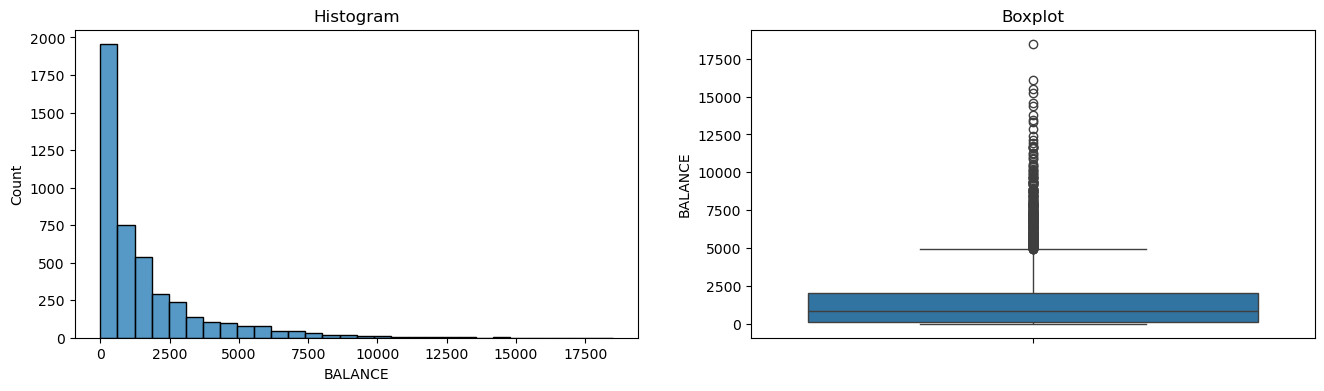


BALANCE - After Capping


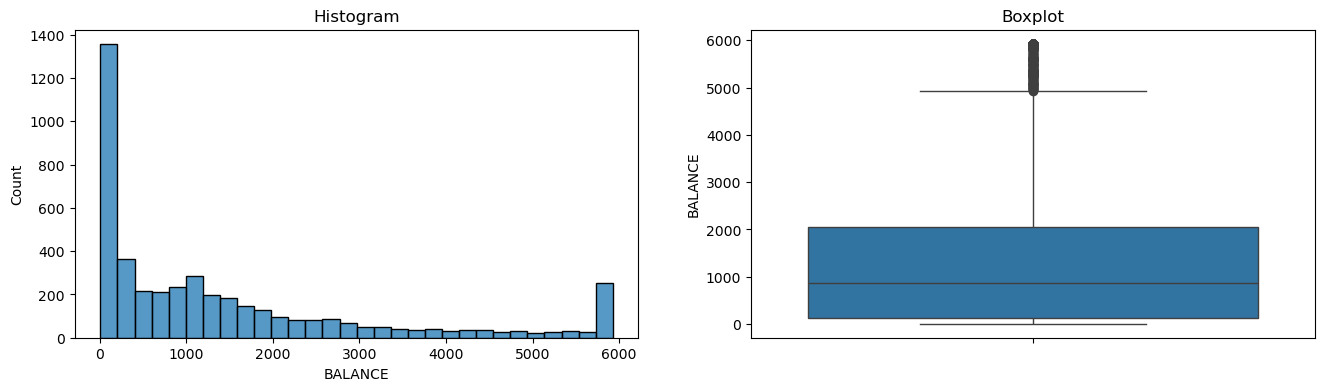

BALANCE_FREQUENCY - Before Capping


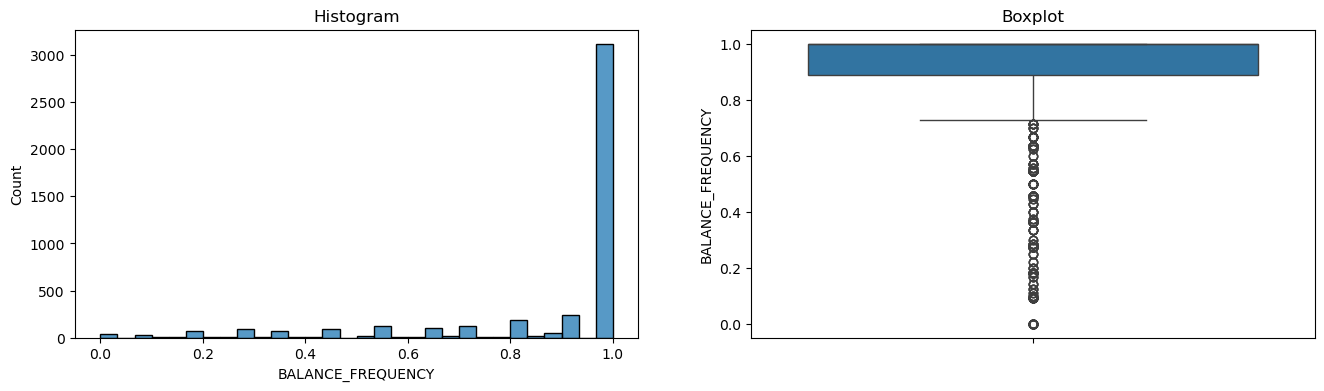


BALANCE_FREQUENCY - After Capping


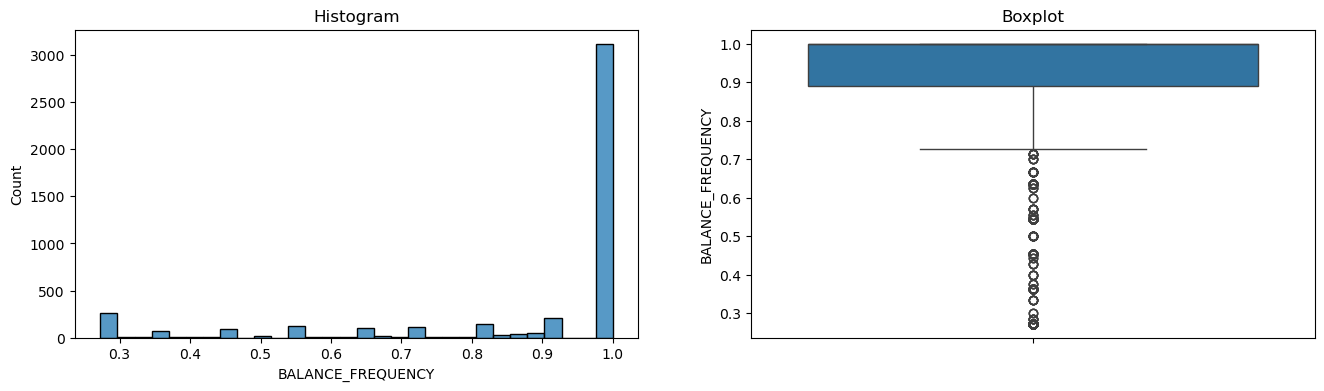

PURCHASES - Before Capping


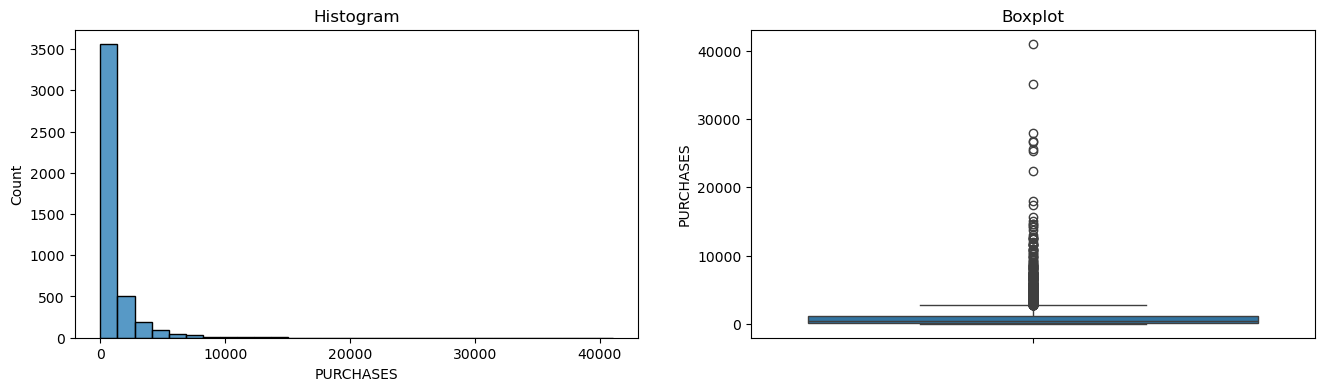


PURCHASES - After Capping


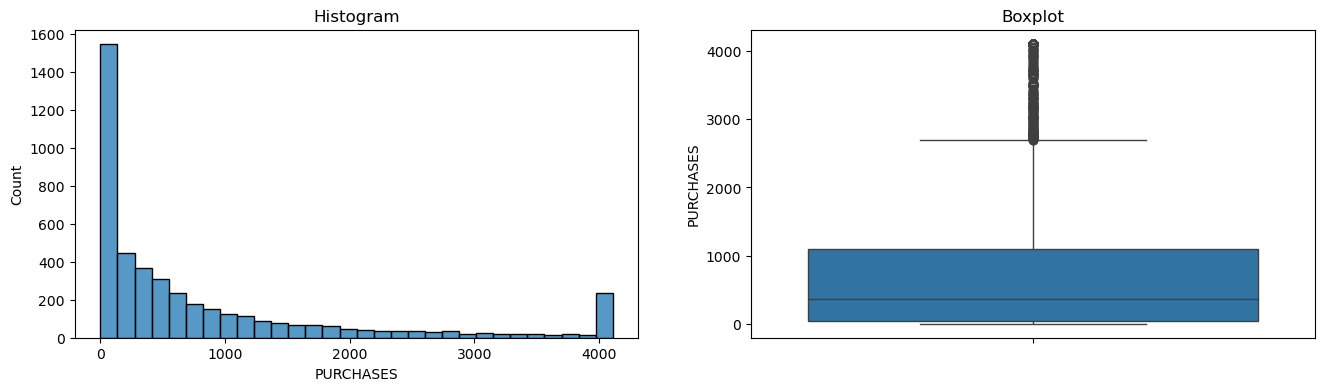

ONEOFF_PURCHASES - Before Capping


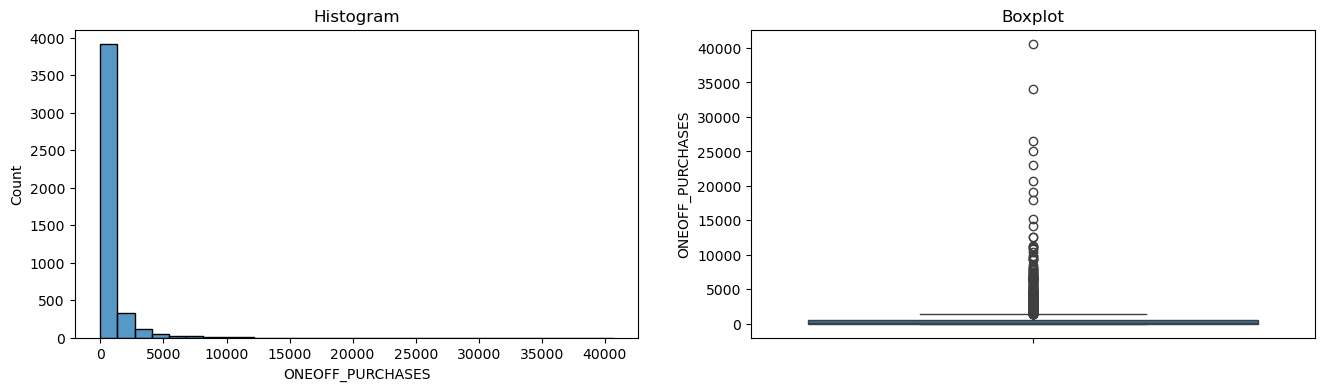


ONEOFF_PURCHASES - After Capping


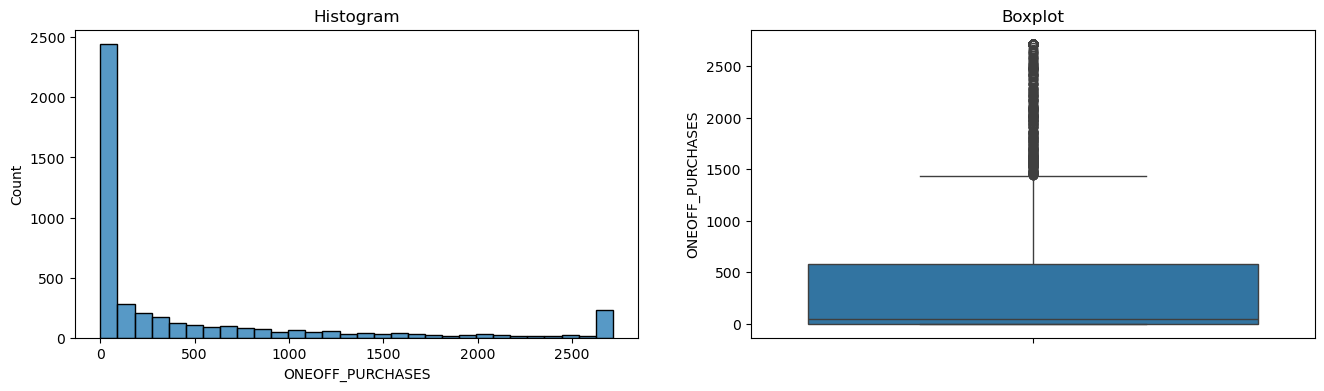

INSTALLMENTS_PURCHASES - Before Capping


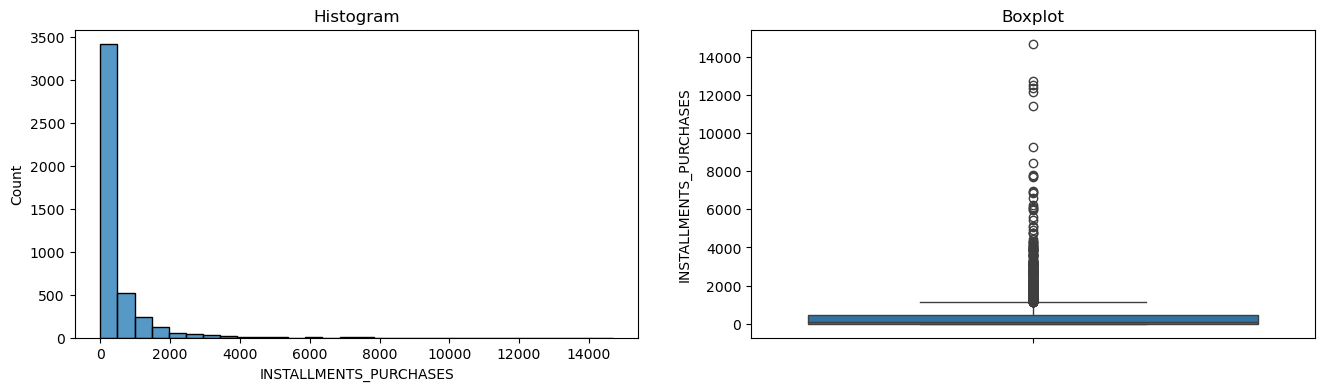


INSTALLMENTS_PURCHASES - After Capping


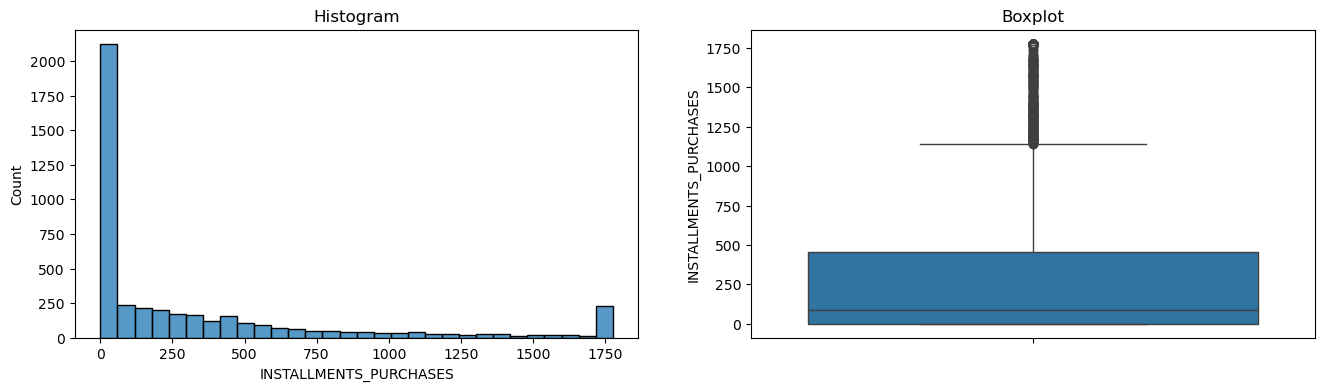

CASH_ADVANCE - Before Capping


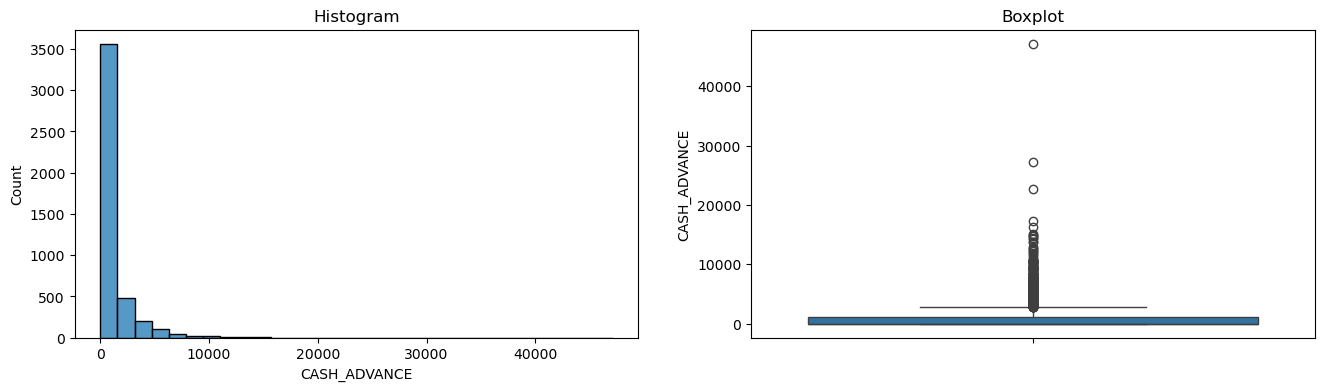


CASH_ADVANCE - After Capping


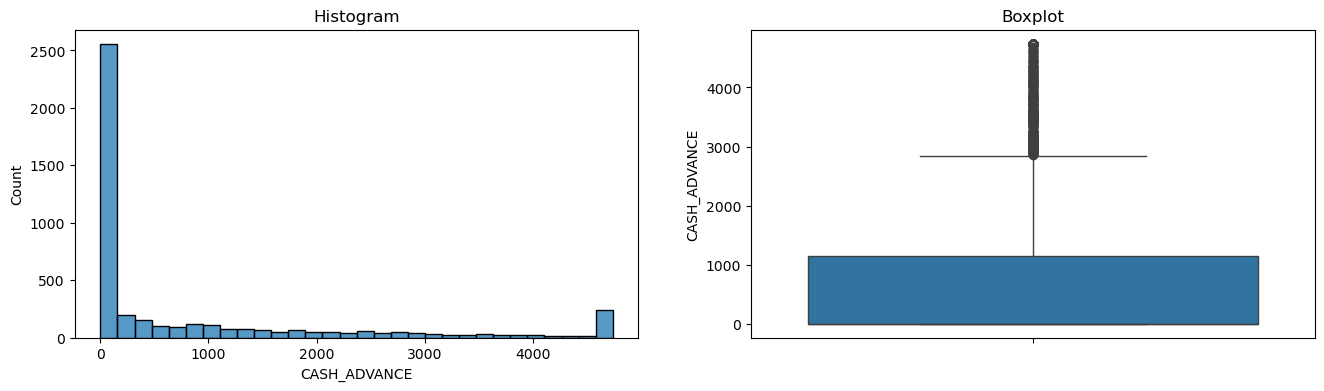

PURCHASES_FREQUENCY - Before Capping


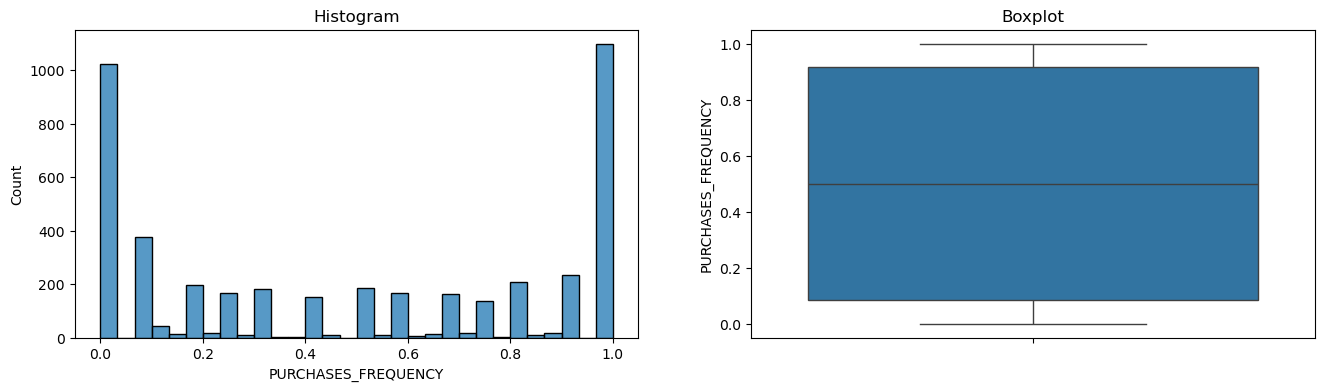


PURCHASES_FREQUENCY - After Capping


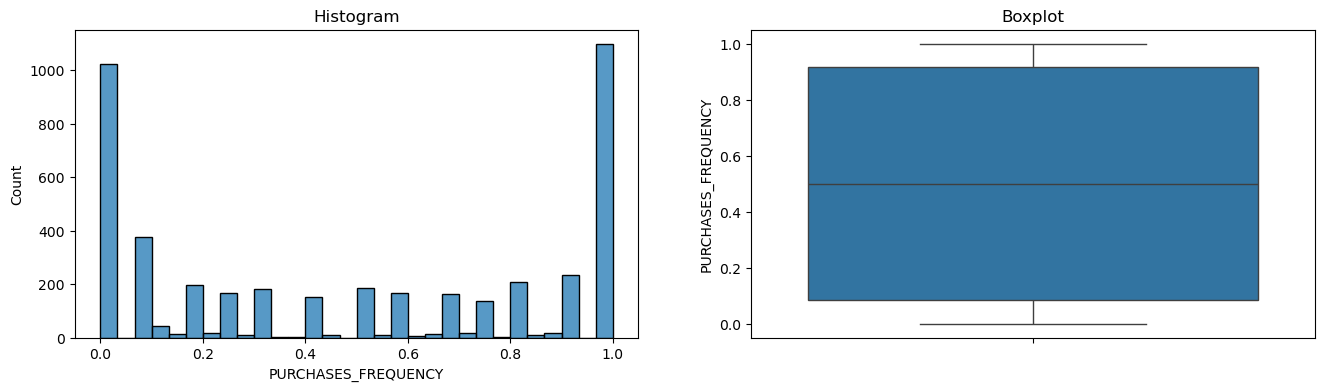

ONEOFF_PURCHASES_FREQUENCY - Before Capping


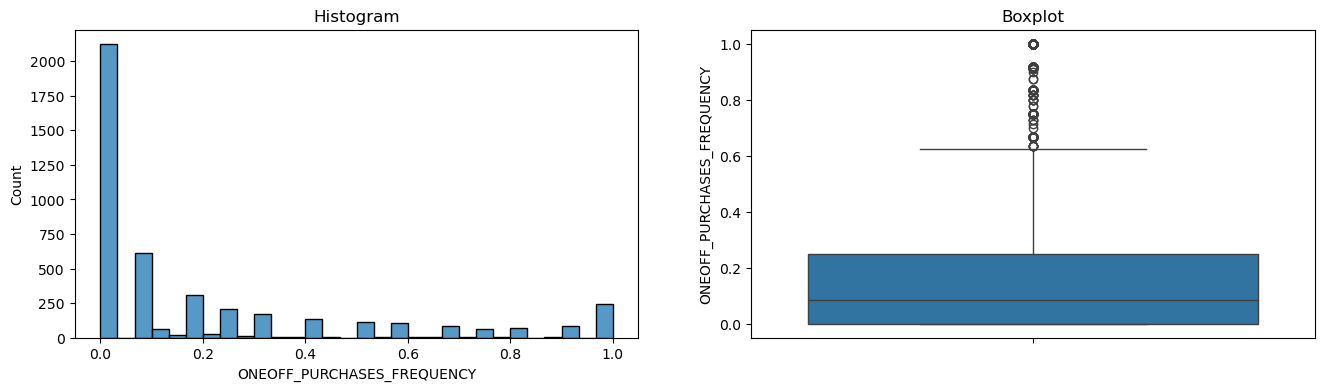


ONEOFF_PURCHASES_FREQUENCY - After Capping


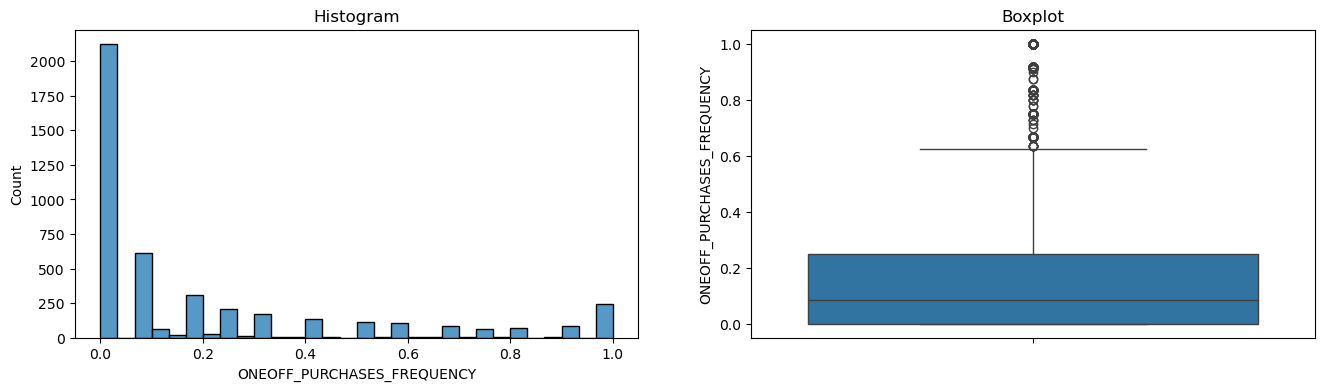

PURCHASES_INSTALLMENTS_FREQUENCY - Before Capping


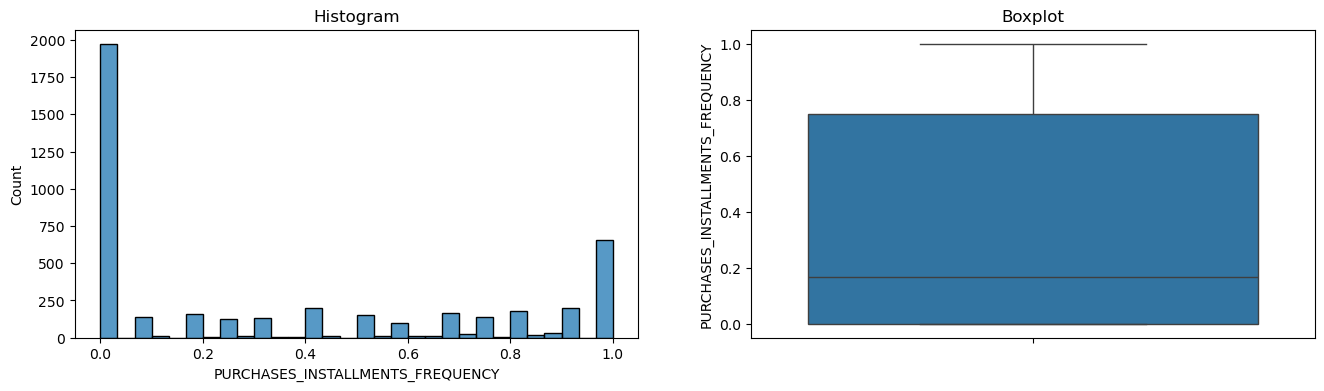


PURCHASES_INSTALLMENTS_FREQUENCY - After Capping


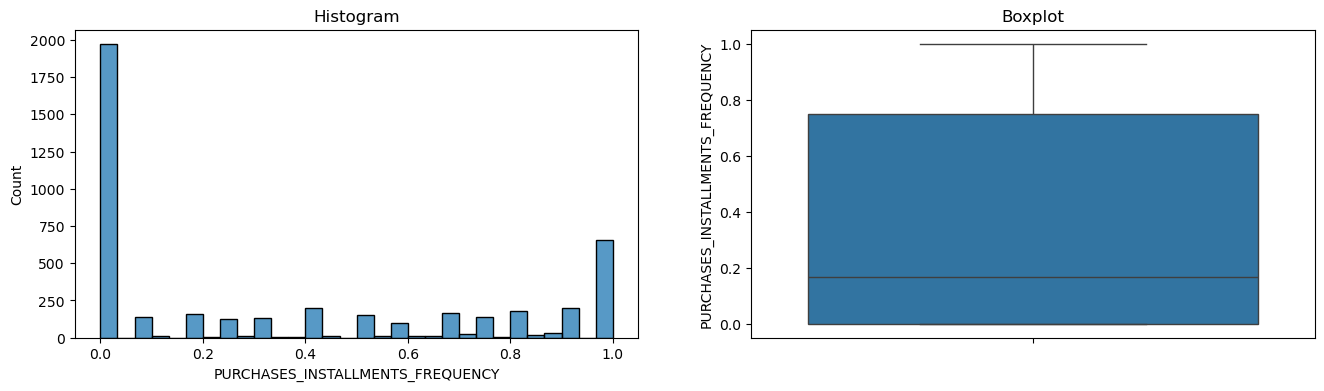

CASH_ADVANCE_FREQUENCY - Before Capping


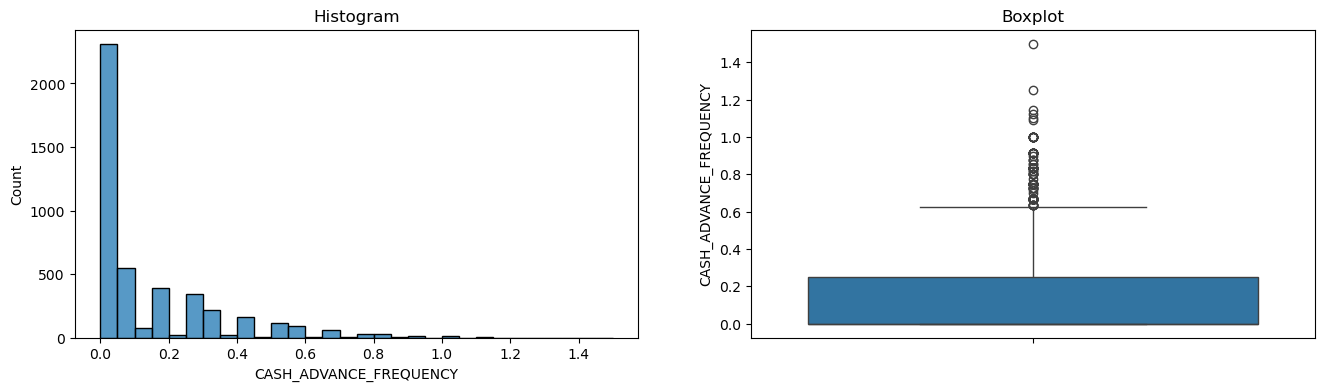


CASH_ADVANCE_FREQUENCY - After Capping


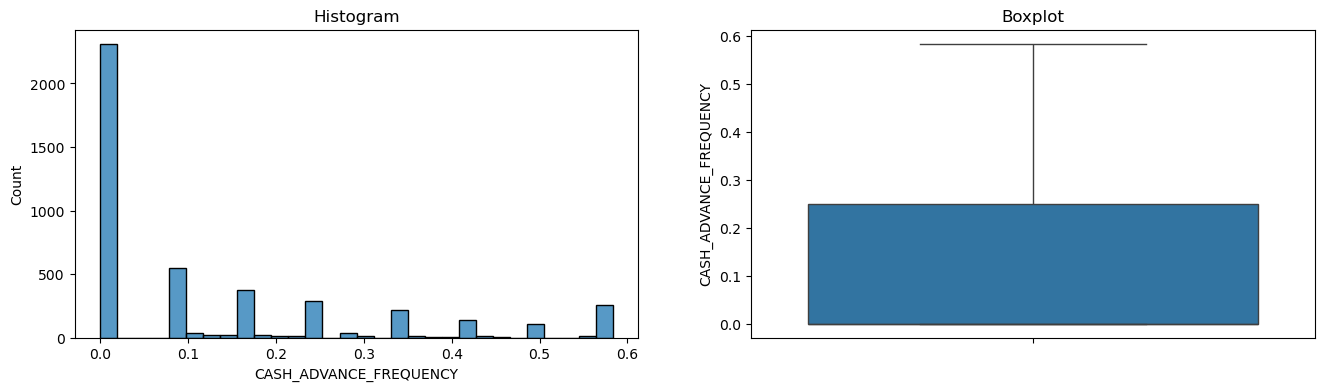

CASH_ADVANCE_TRX - Before Capping


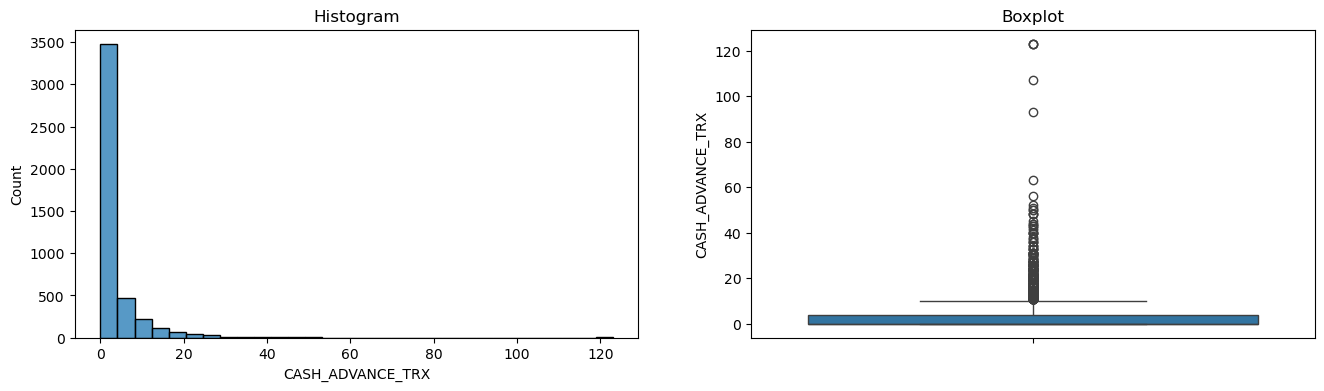


CASH_ADVANCE_TRX - After Capping


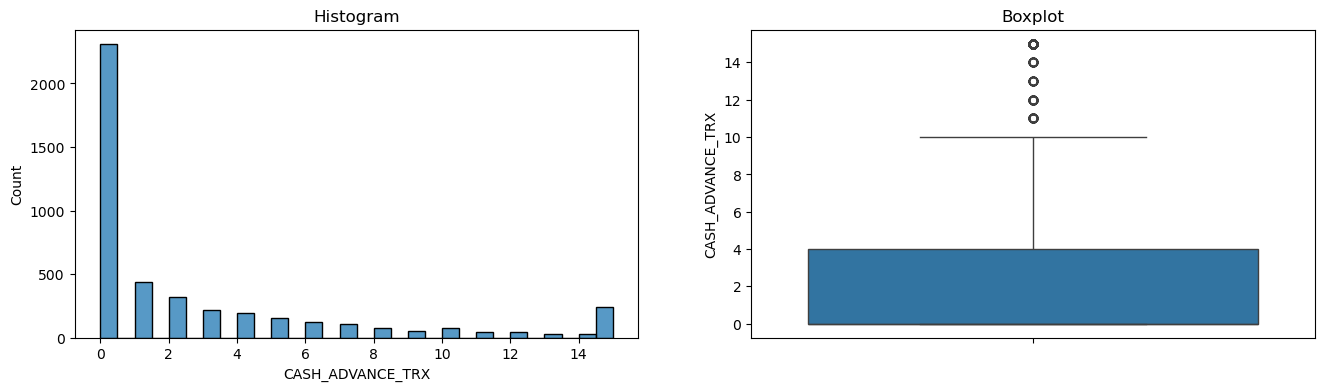

PURCHASES_TRX - Before Capping


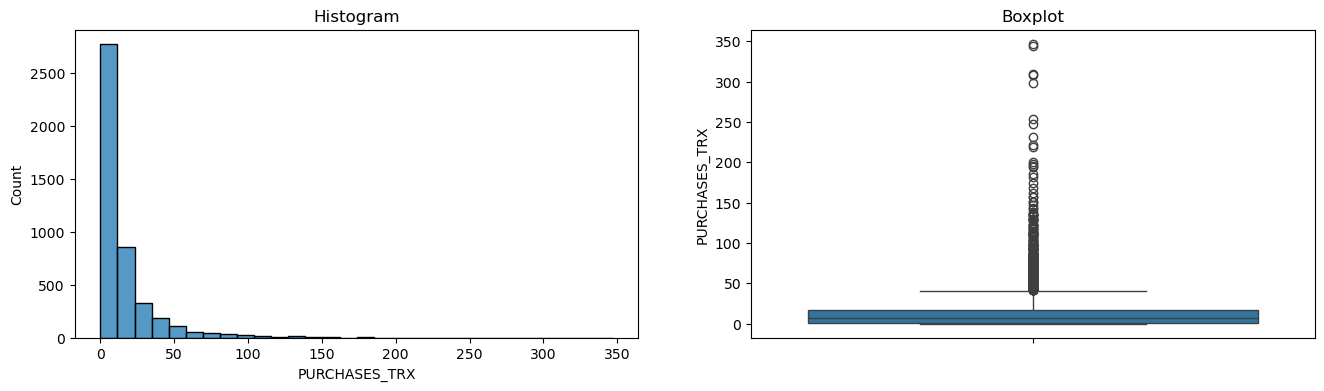


PURCHASES_TRX - After Capping


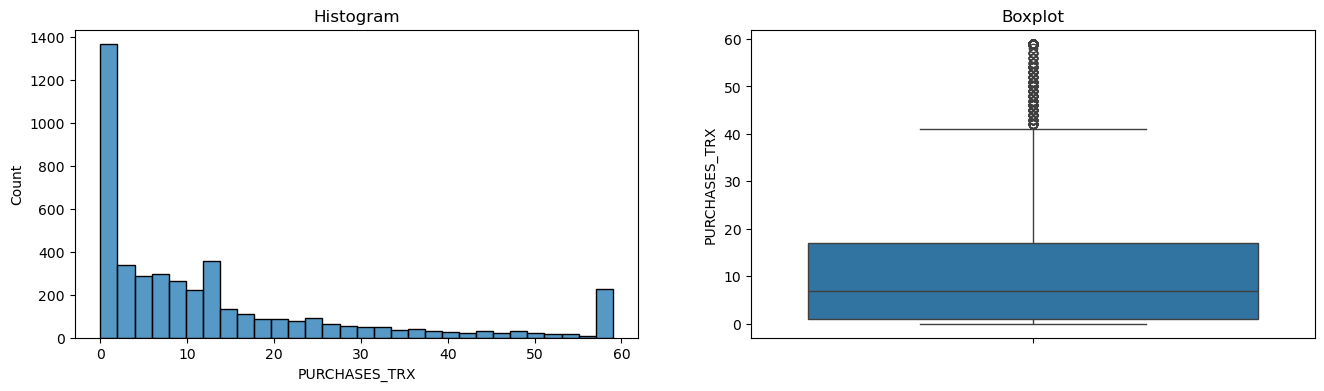

CREDIT_LIMIT - Before Capping


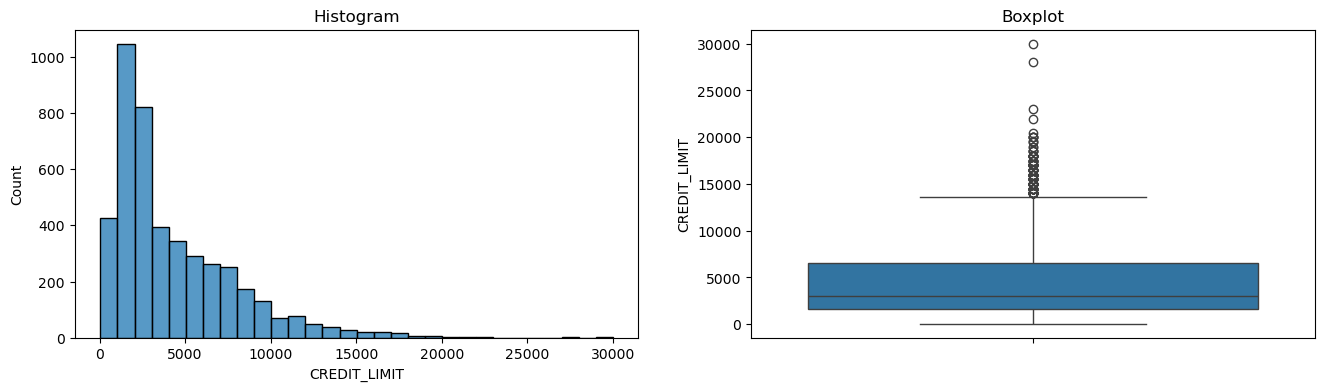


CREDIT_LIMIT - After Capping


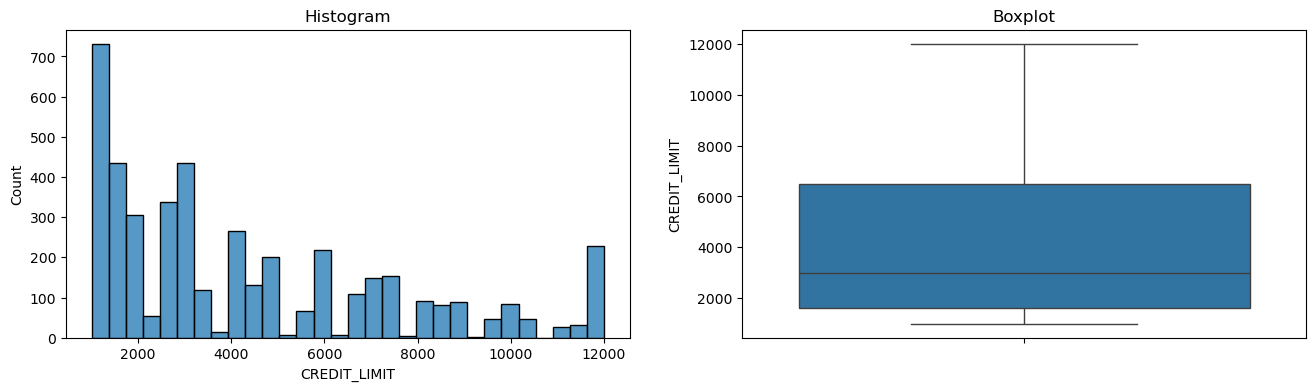

PAYMENTS - Before Capping


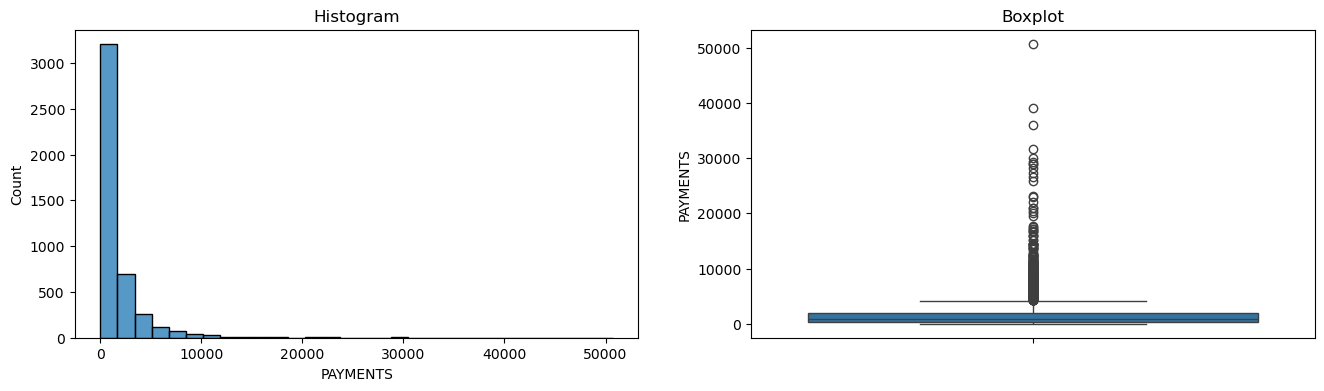


PAYMENTS - After Capping


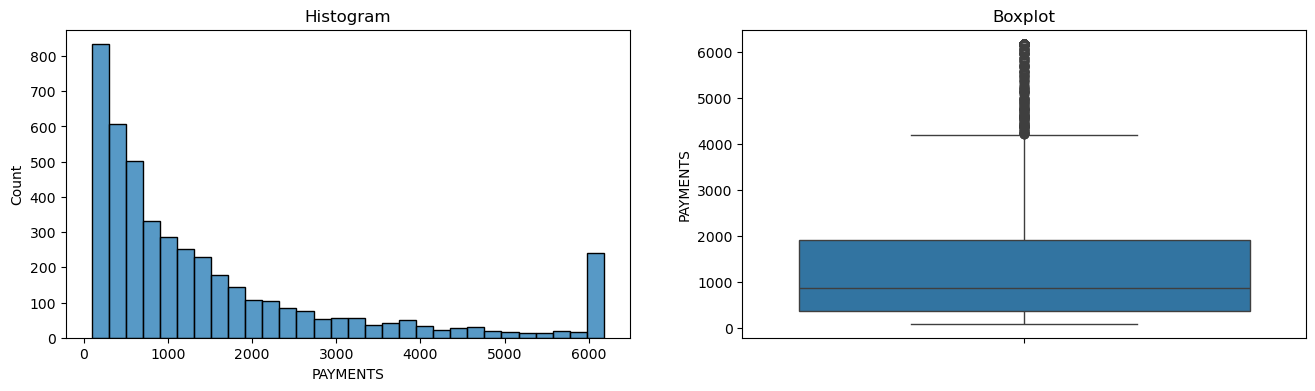

MINIMUM_PAYMENTS - Before Capping


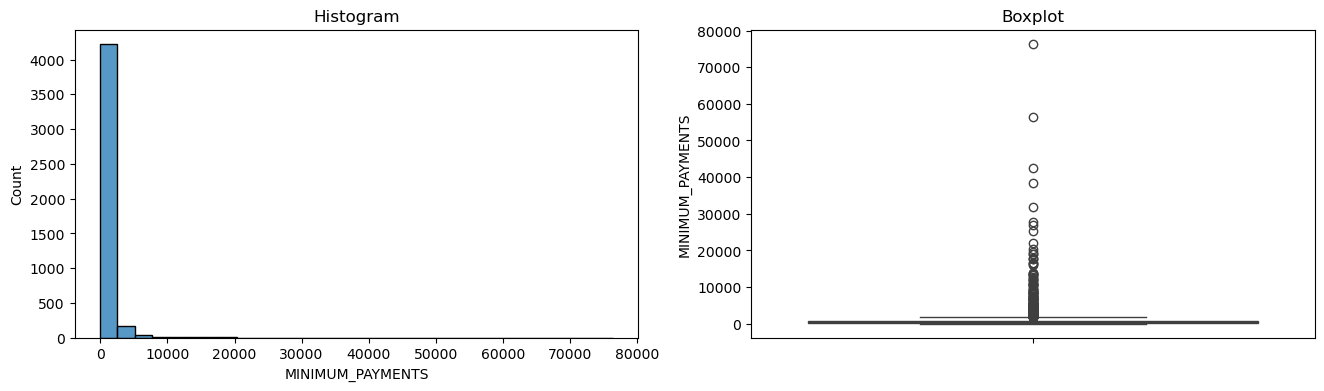


MINIMUM_PAYMENTS - After Capping


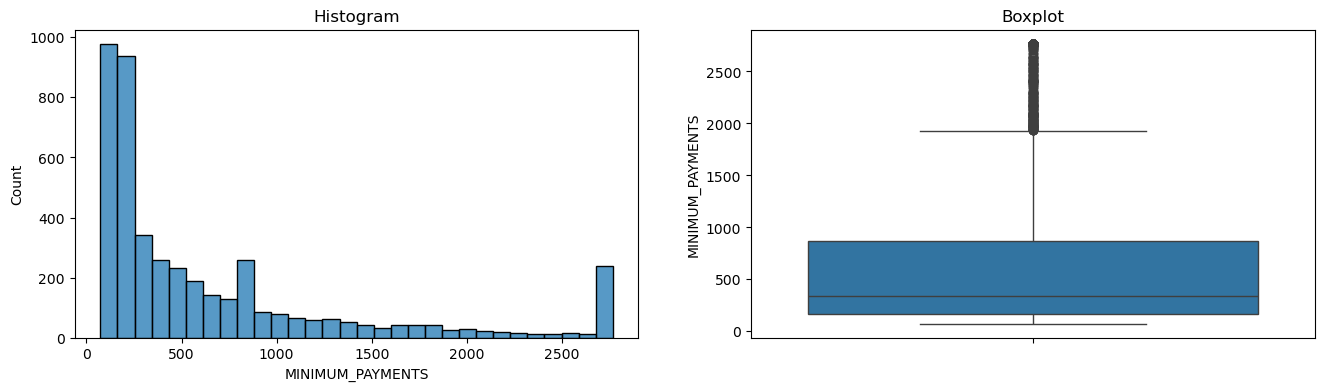

PRC_FULL_PAYMENT - Before Capping


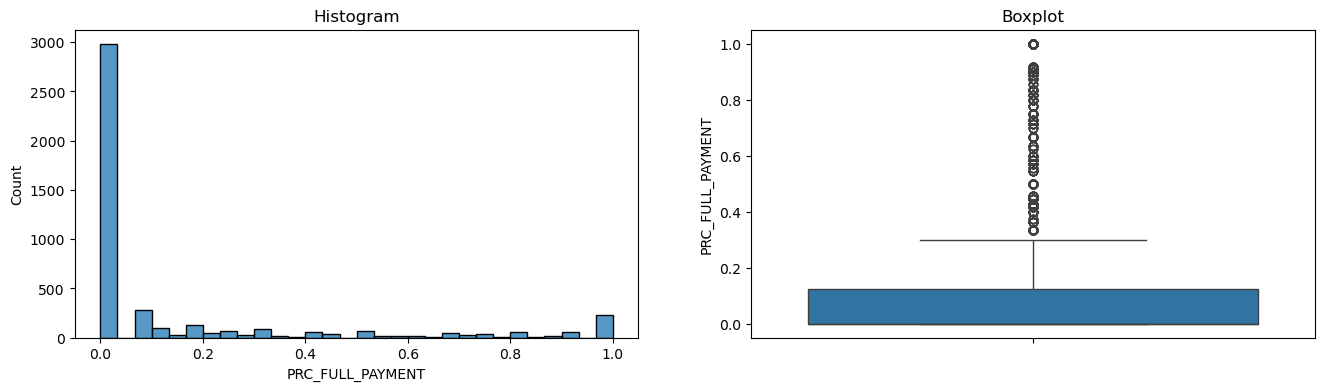


PRC_FULL_PAYMENT - After Capping


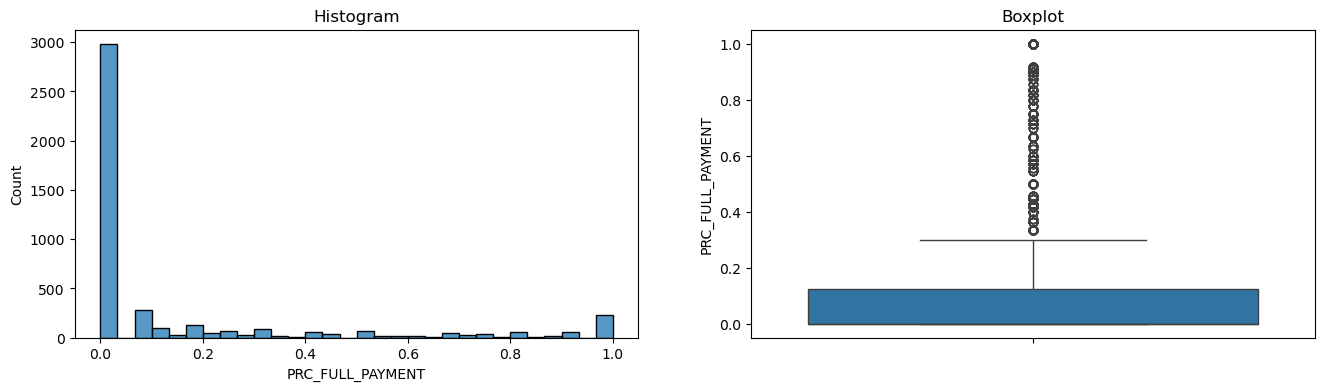

TENURE - Before Capping


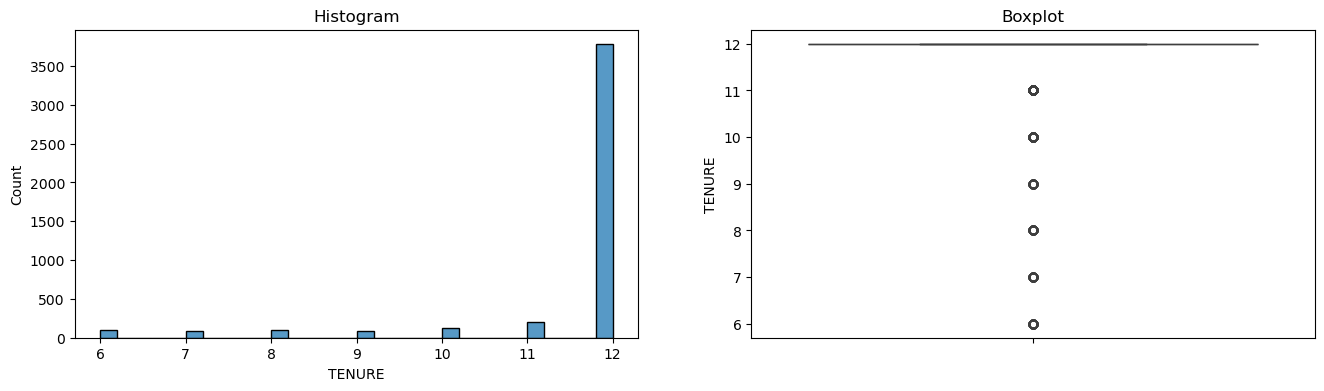


TENURE - After Capping


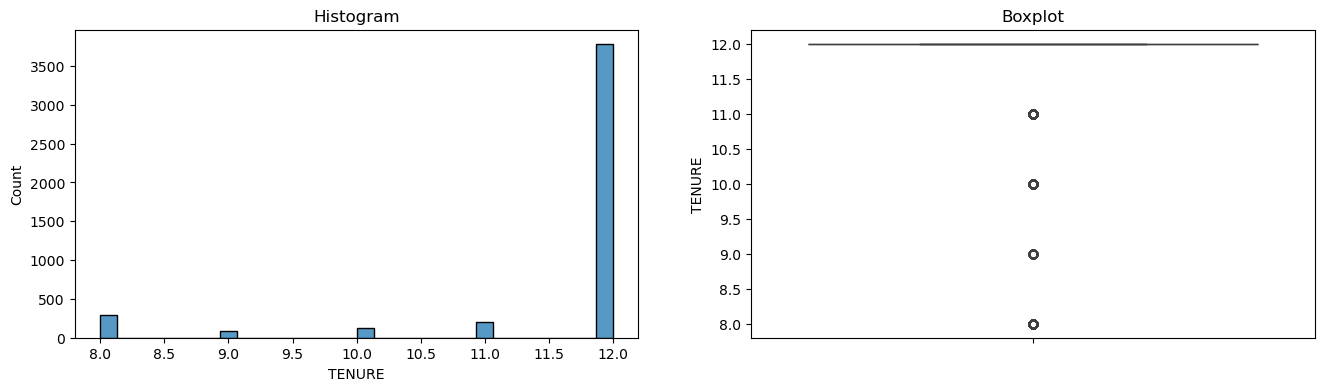

In [29]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')


    plt.show()
# Check the distribution before and after capping
for col in num_cols:
  print(f'{col} - Before Capping')
  diagnostic_plots(data_fe, col)

  print(f'\n{col} - After Capping')
  diagnostic_plots(data_fe_capped, col)

In [30]:
def calculate_outliers(data_fe, skewness):
    # Inisialisasi list untuk menyimpan hasil
    column = []
    lower_bound = []
    upper_bound = []
    percent_total_outlier = []

    # Loop untuk menghitung outlier
    for row in range(len(skewness)):
        col = skewness['nama kolom'][row]

        # Memeriksa batas atas dan bawah
        if skewness['distribution'][row] == 'skewed':
            IQR = data_fe[col].quantile(0.75) - data_fe[col].quantile(0.25)
            lower_boundary = data_fe[col].quantile(0.25) - (IQR * 3)
            upper_boundary = data_fe[col].quantile(0.75) + (IQR * 3)
        else:
            lower_boundary = data_fe[col].mean() - 3 * data_fe[col].std()
            upper_boundary = data_fe[col].mean() + 3 * data_fe[col].std()

        # Menambahkan ke list
        column.append(col)
        lower_bound.append(lower_boundary)
        upper_bound.append(upper_boundary)
        
        # Menghitung persentase total outlier
        totout = ((len(data_fe[data_fe[col] > upper_boundary]) / len(data_fe) * 100) +
                   (len(data_fe[data_fe[col] < lower_boundary]) / len(data_fe) * 100))
        percent_total_outlier.append(totout)

    # Membuat DataFrame hasil
    outliers = pd.DataFrame({
        'column': column,
        'upper_boundary': [round(ub, 2) for ub in upper_bound],
        'lower_boundary': [round(lb, 2) for lb in lower_bound],
        'percentage_total_outlier': [round(percent, 2) for percent in percent_total_outlier]
    })

    return outliers

outliers = calculate_outliers(data_fe_capped, skewness)
outliers

column  upper_boundary  lower_boundary  \
0                            BALANCE         7816.98        -5644.98   
1                  BALANCE_FREQUENCY            1.33            0.56   
2                          PURCHASES         4291.00        -3149.02   
3                   ONEOFF_PURCHASES         2300.88        -1725.66   
4             INSTALLMENTS_PURCHASES         1823.54        -1367.66   
5                       CASH_ADVANCE         4555.55        -3416.66   
6                PURCHASES_FREQUENCY            1.70           -0.72   
7         ONEOFF_PURCHASES_FREQUENCY            1.00           -0.75   
8   PURCHASES_INSTALLMENTS_FREQUENCY            1.56           -0.83   
9             CASH_ADVANCE_FREQUENCY            1.00           -0.75   
10                  CASH_ADVANCE_TRX           16.00          -12.00   
11                     PURCHASES_TRX           65.00          -47.00   
12                      CREDIT_LIMIT        21200.00       -13100.00   
13                          PAYMENTS         6515.65        -4227.14   
14                  MINIMUM_PAYMENTS         2984.53        -1940.10   
15                  PRC_FULL_PAYMENT            0.50           -0.38   
16                            TENURE           12.00           12.00   

    percentage_total_outlier  
0                       0.00  
1                      13.43  
2                       0.00  
3                       6.41  
4                       0.00  
5                       5.36  
6                       0.00  
7                       0.00  
8                       0.00  
9                       0.00  
10                      0.00  
11                      0.00  
12                      0.00  
13                      0.00  
14                      0.00  
15                     12.13  
16                     15.60

## Scaling 

In [31]:
# Feature Scaling

scaler = StandardScaler()
scaler.fit(data_fe_capped)

data_fe = scaler.transform(data_fe_capped)

Untuk proses scaling kita menggunakan `StandarScaler` pada semua kolom dikarenakan `StandarScaler` merupakan scaler yang paling cocok jika kita akan melanjutkan proses ke tahap PCA

## PCA

In [32]:
pca = PCA(random_state=10)
pca.fit(data_fe)

PCA(random_state=10)

Text(0, 0.5, 'Eigenvalues')

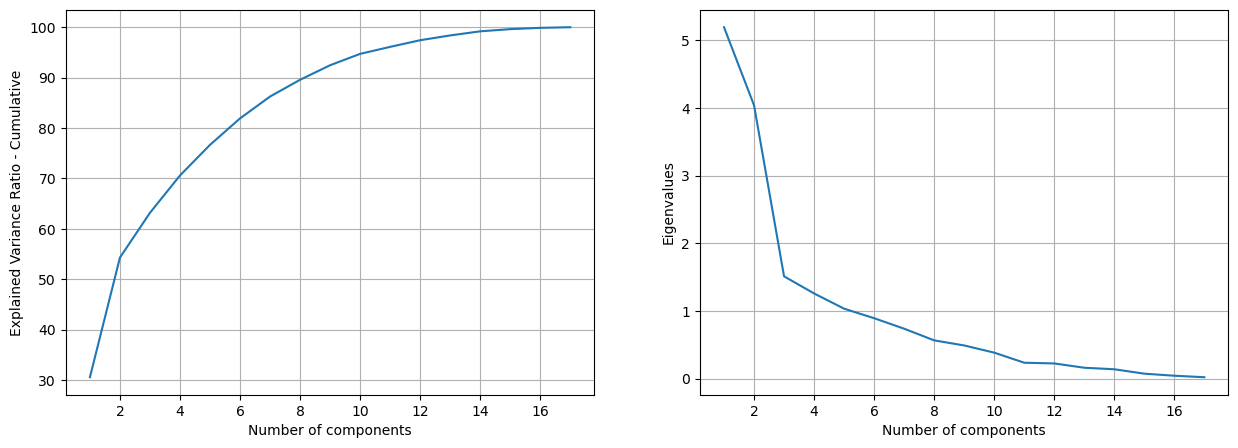

In [33]:
# Adjust the range to match the length of the PCA components
num_components = len(pca.explained_variance_ratio_)  # This will dynamically get the correct length

# Plot the Cumulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, num_components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cumulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, num_components + 1), pca.explained_variance_)
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')



Berdasarkan grafik, akan digunakan 80% dari informasi yang tersedia, karena setelah titik tersebut, perbedaannya tidak lagi signifikan. Ini menunjukkan bahwa sebagian besar variasi atau informasi penting telah terwakili hingga 80%, sehingga menambahkan data setelahnya tidak akan memberikan peningkatan yang berarti

In [34]:
# Check the number of features if we want to retain 95 % of the information
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.8) + 1
num_features

6

Dari total 16 fitur, cukup 6 fitur saja yang dibutuhkan untuk mencakup 80% dari informasi pada data yang dimiliki

In [35]:
pca = PCA(n_components=0.8,random_state=10)
pca.fit(data_fe)

data_fe_scaled_pca = pca.transform(data_fe)

## Find Best Cluster

### ELBOW Method

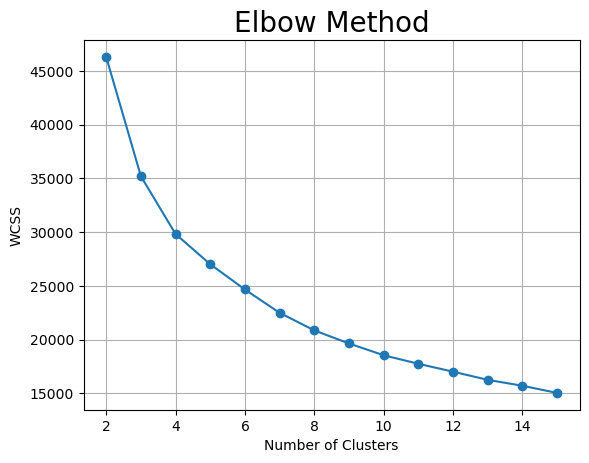

In [36]:
# Find the optimal number of clusters using Elbow Method

wcss = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(data_fe_scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Dari Visualisasi Elbow diatas, dapat dilihat pada grafik cluster 3 menunjukan perubahan yang signifikan, pada grafik setelah angka 3 terlihat tidak lagi menunjukan perubahan yang signifikan dan cenderung sama.

In [37]:
# Function to create Silhouette Plot

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

### Silhoutte Plot & Silhoutte Score

For n_clusters = 2 The average silhouette_score is : 0.30349612463335246
For n_clusters = 3 The average silhouette_score is : 0.28967087842988753
For n_clusters = 4 The average silhouette_score is : 0.2501910682675519
For n_clusters = 5 The average silhouette_score is : 0.2394669276882115
For n_clusters = 6 The average silhouette_score is : 0.24315862807421124
For n_clusters = 7 The average silhouette_score is : 0.2574761613789635
For n_clusters = 8 The average silhouette_score is : 0.26213280825115626
For n_clusters = 9 The average silhouette_score is : 0.24491299736127597
For n_clusters = 10 The average silhouette_score is : 0.24408155678143134
For n_clusters = 11 The average silhouette_score is : 0.24531117327871943
For n_clusters = 12 The average silhouette_score is : 0.23935584803056528
For n_clusters = 13 The average silhouette_score is : 0.24049871162708347
For n_clusters = 14 The average silhouette_score is : 0.24621659114486022


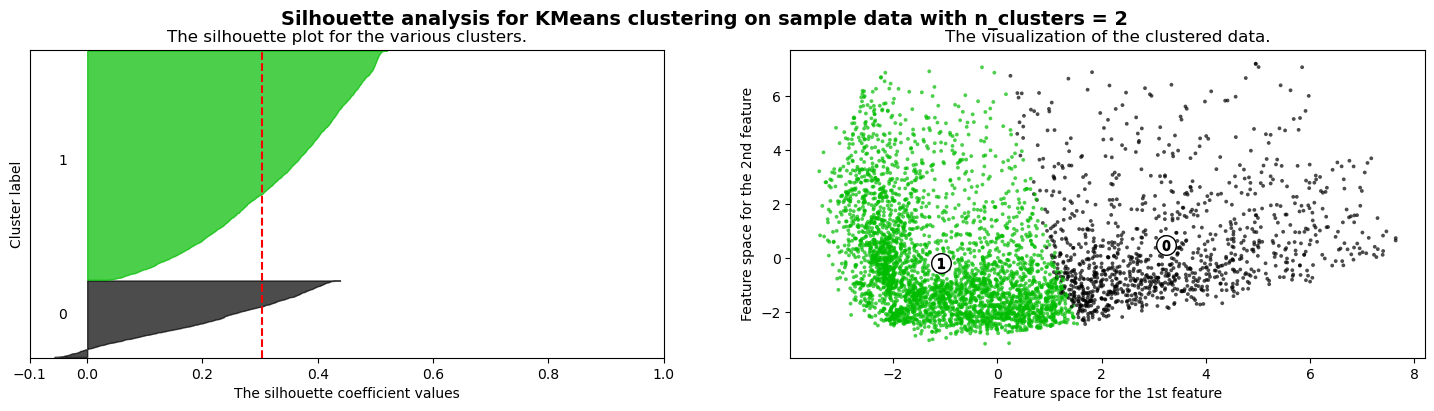

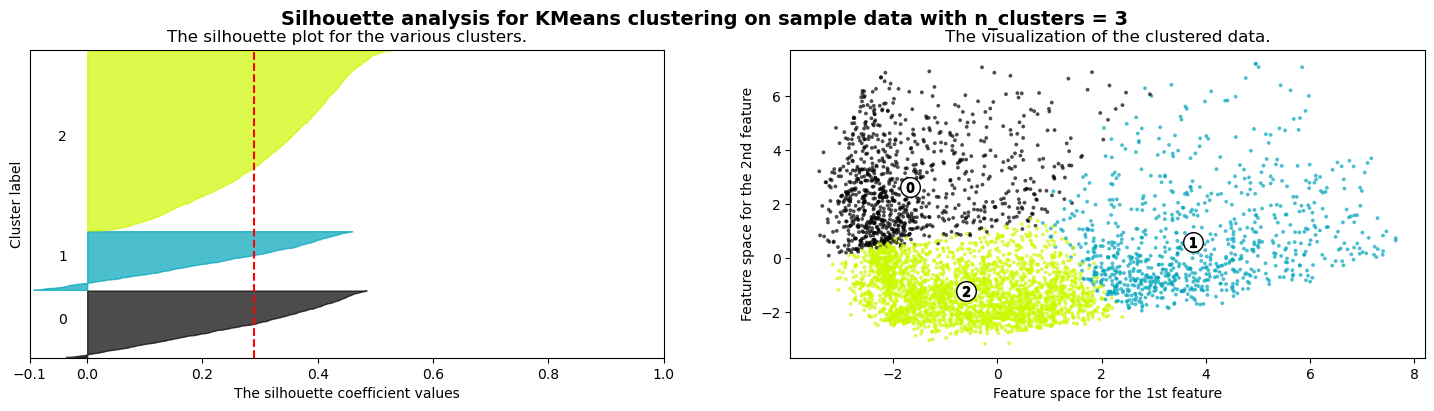

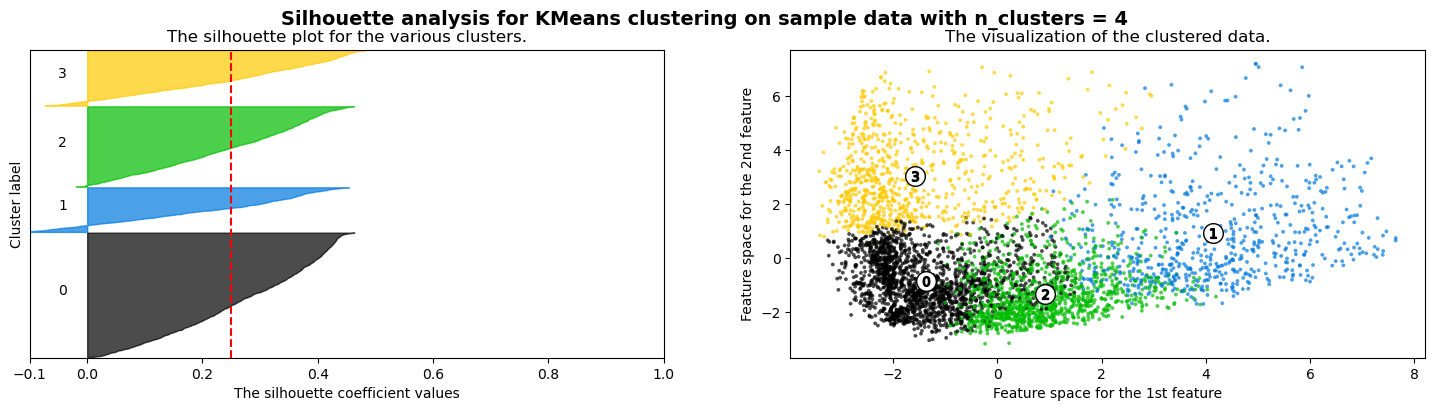

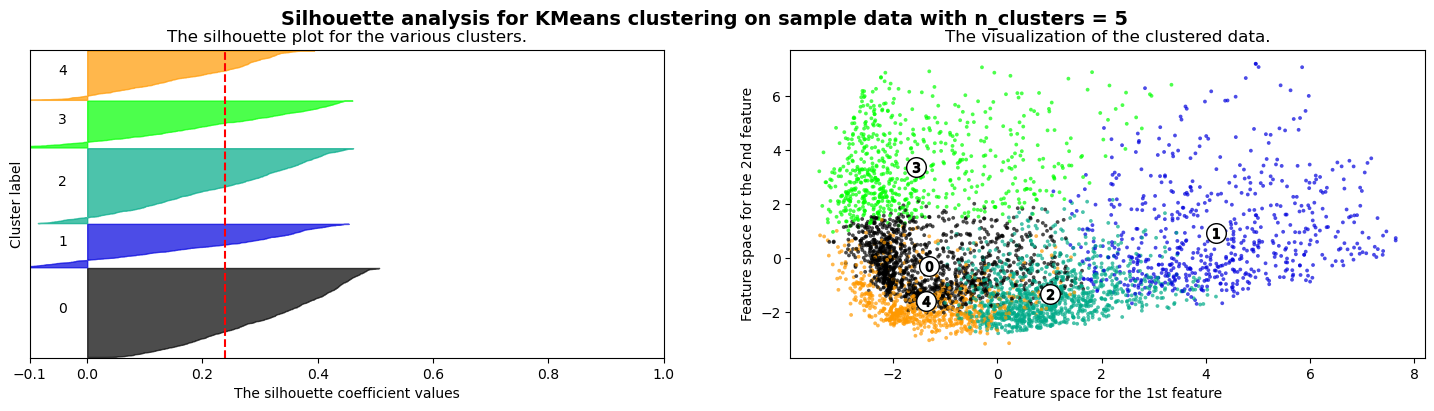

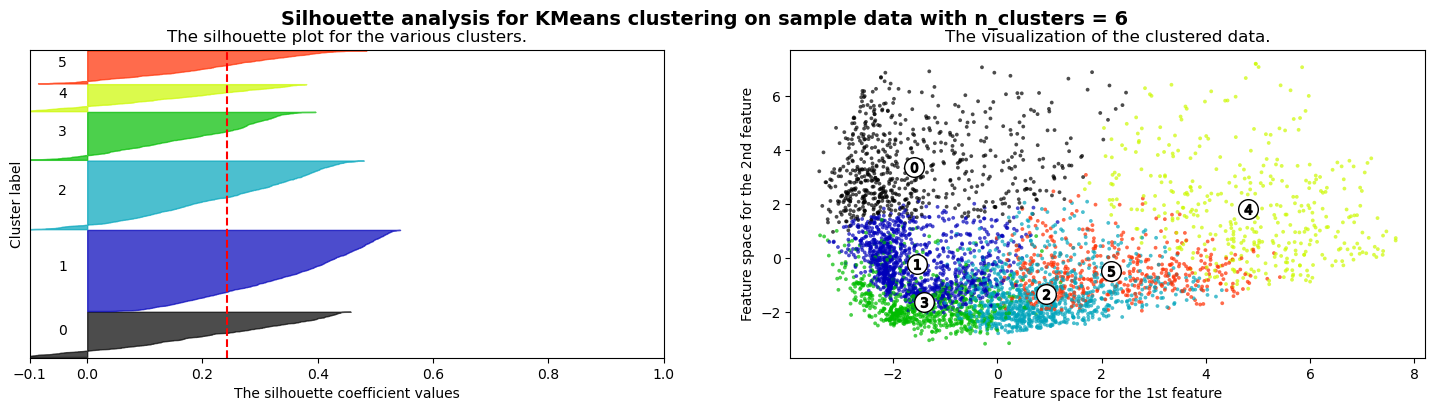

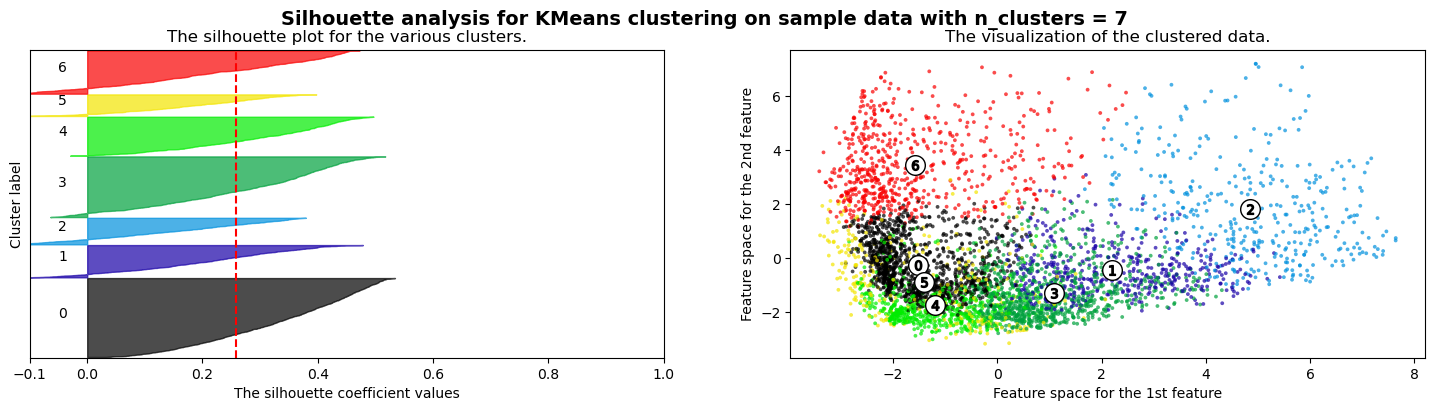

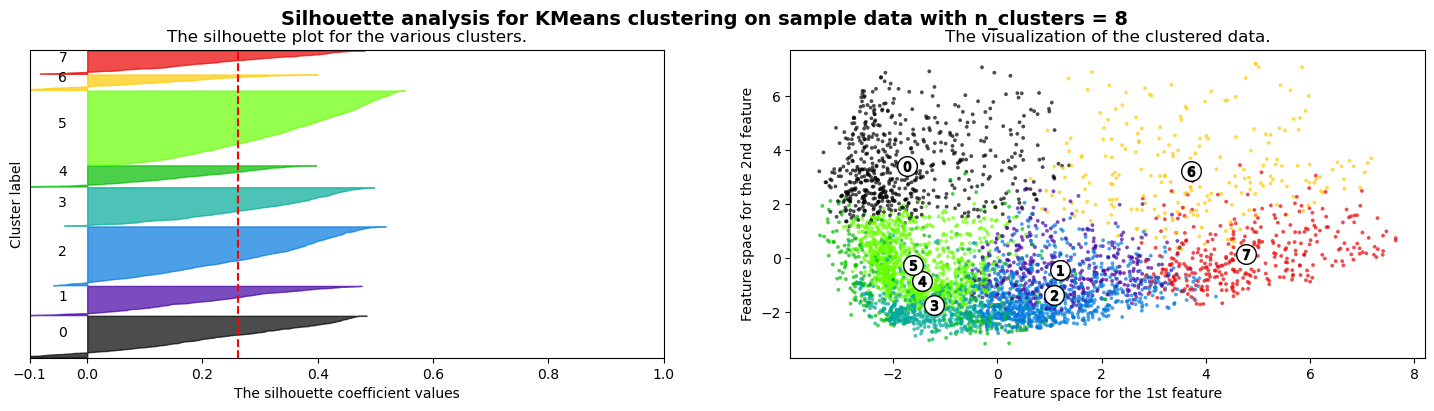

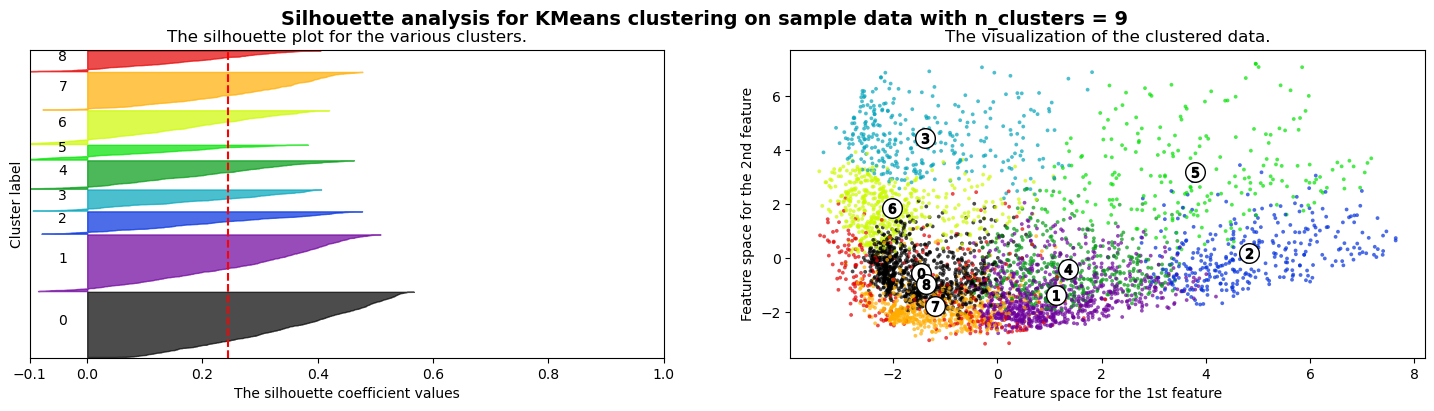

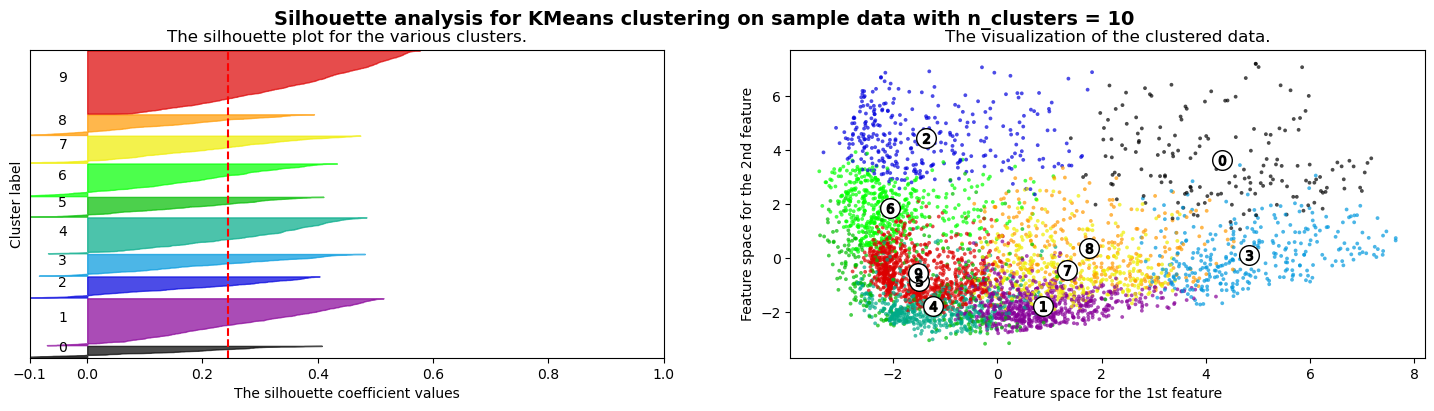

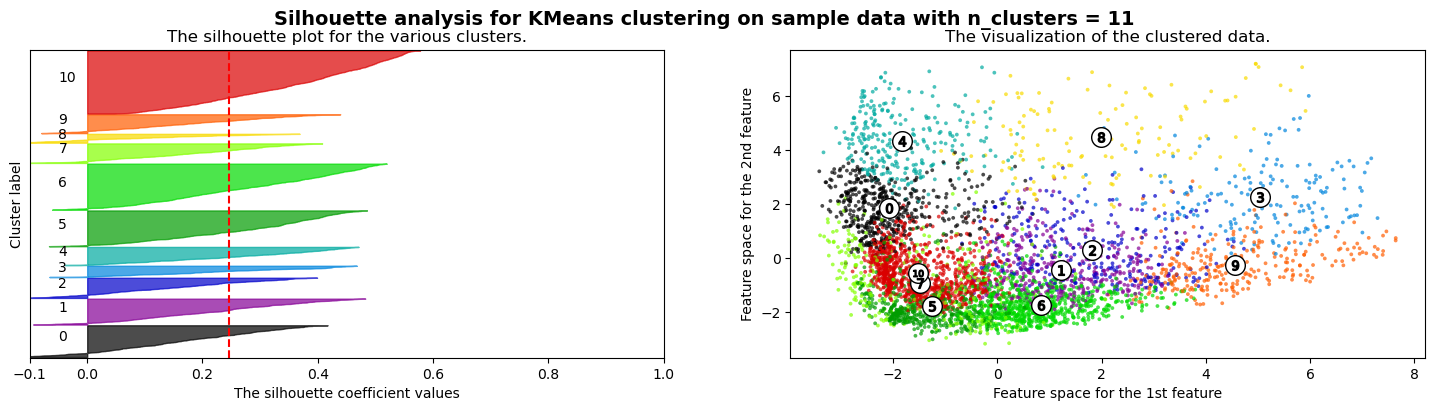

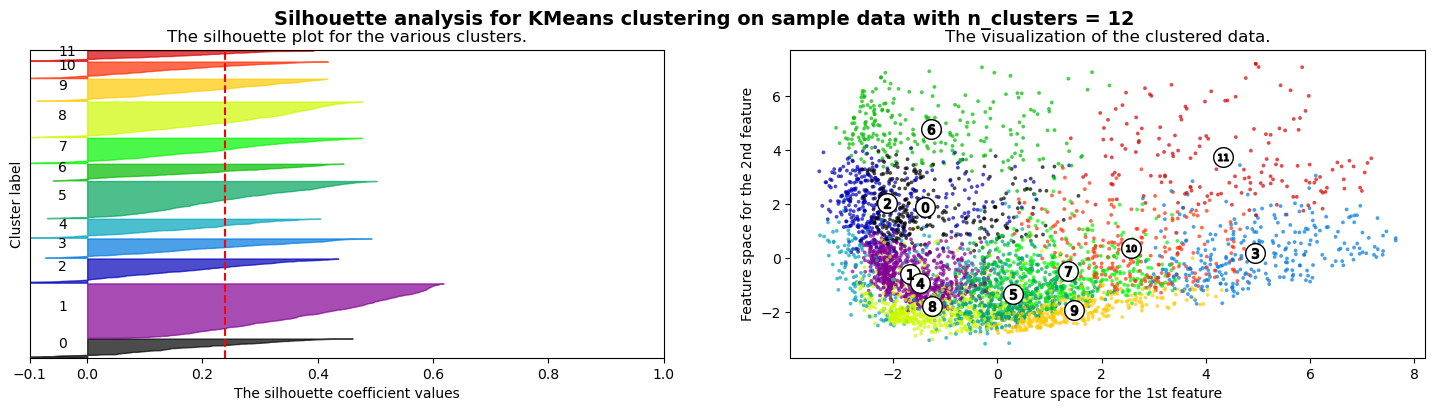

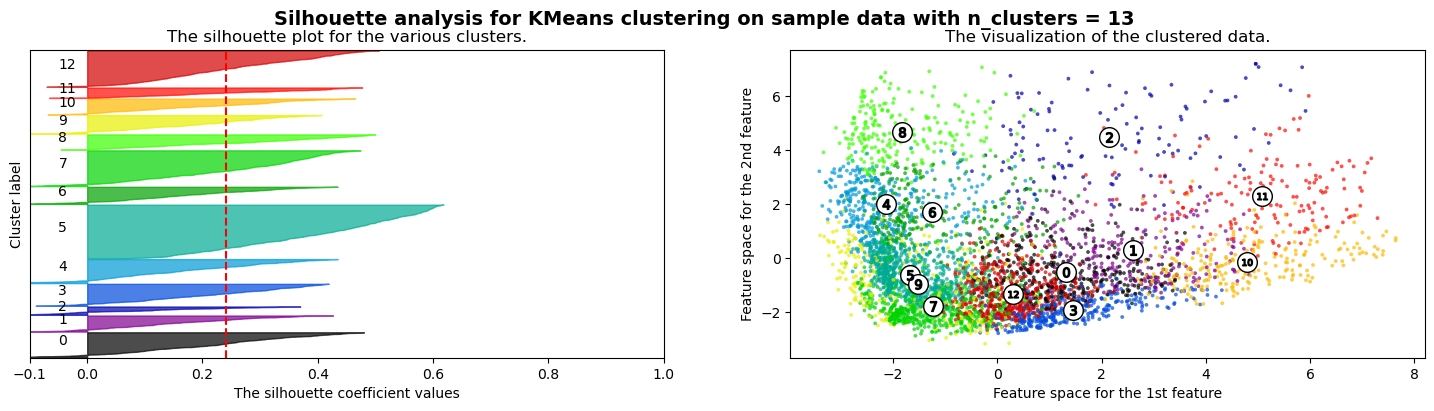

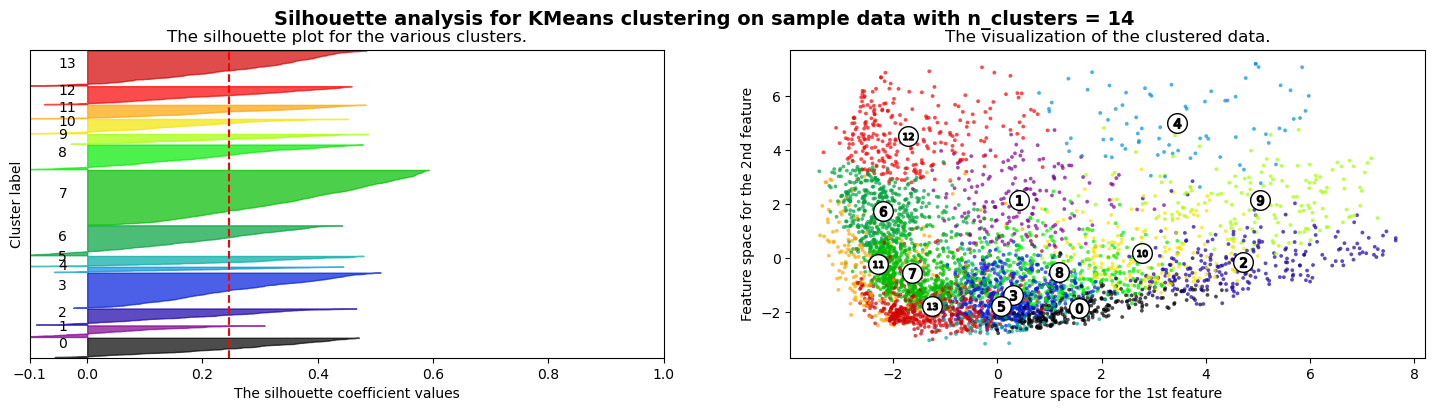

In [38]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), data_fe_scaled_pca, random_state)

Dari hasil visualisasi diatas, diketahui : Silhoutte score dengan n_clusters = 3 terlihat adalah cluster yang paling cocok pada data ini , karena hasil silhoutte score n_clusters yang lainnya cenderung memiliki kemiripan.

# Model Definition

Pada proyek ini akan digunakan Algoritma K-Means Clustering  untuk melakukan segmentasi pelanggan pada data kartu kredit ini, K-Means adalah pilihan tepat untuk segmentasi pelanggan yang membutuhkan hasil cepat, efisien, dan mudah dipahami.

**Pemilihan Hyperparameter:**

- **n_clusters:** Jumlah cluster optimal ditentukan menggunakan Elbow Method dan Silhouette Score. setelah dilakukan pencarian `best cluster` kita akan mengelompokan data kedalam 3 cluster
- **init:** Inisialisasi centroid menggunakan parameter 'k-means++', yang membantu mempercepat konvergensi dan mencegah inisialisasi yang buruk.
- **max_iter:** Iterasi maksimum diatur menjadi 300 untuk memastikan algoritma memiliki cukup waktu untuk mencapai konvergensi.
- **random_state:** Nilai random_state ditetapkan agar hasil clustering konsisten setiap kali model dijalankan.

# Model Training

In [39]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
km.fit(data_fe_scaled_pca)


KMeans(n_clusters=3, n_init=10, random_state=10)

In [40]:
pred=km.predict(data_fe_scaled_pca)
pred

array([2, 2, 2, ..., 0, 0, 0])

In [41]:
# Cek iterasi keberapa data konvergen
km.n_iter_

16

## Data Final

In [42]:
# Tambahkan Clustering kedalam data awal
data['cluster'] = pred
data

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0        3091     3.833185              0.125      45.00             45.00   
1        5069     0.000000              0.000     176.03            176.03   
2        6075   757.964752              0.875     157.40            157.40   
3        6291   264.566591              0.375    1150.00           1150.00   
4        7755   440.613643              1.000     600.00            600.00   
...       ...          ...                ...        ...               ...   
4470     2345  9629.808851              1.000       0.00              0.00   
4471     6785  1040.030221              1.000       0.00              0.00   
4472     7347  1322.818587              1.000       0.00              0.00   
4473     8447  1060.391273              1.000       0.00              0.00   
4474     1995  3447.674222              1.000     205.00            205.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                        0.0      0.000000             0.125000   
1                        0.0      0.000000             0.125000   
2                        0.0      0.000000             0.125000   
3                        0.0      0.000000             0.125000   
4                        0.0      0.000000             0.125000   
...                      ...           ...                  ...   
4470                     0.0   4372.393835             0.000000   
4471                     0.0   1390.648290             0.000000   
4472                     0.0    762.301096             0.000000   
4473                     0.0   1475.858013             0.000000   
4474                     0.0   4548.057776             0.090909   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125000                               0.0   
1                       0.125000                               0.0   
2                       0.125000                               0.0   
3                       0.125000                               0.0   
4                       0.125000                               0.0   
...                          ...                               ...   
4470                    0.000000                               0.0   
4471                    0.000000                               0.0   
4472                    0.000000                               0.0   
4473                    0.000000                               0.0   
4474                    0.090909                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              1         500.0   
1                   0.000000                 0              1        7000.0   
2                   0.000000                 0              6        1200.0   
3                   0.000000                 0              1        1200.0   
4                   0.000000                 0              1        1000.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0       12000.0   
4471                0.545455                18              0        1400.0   
4472                0.545455                11              0        1500.0   
4473                0.545455                10              0        2000.0   
4474                0.545455                 7              1       10500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0        0.000000               NaN               0.0       8        2  
1        0.000000               NaN               0.0       8        2  
2     1494.480376       2638.598410               0.0       8        2  
3     3029.380326         85.428885               0.0       8        2  
4      215.316424        137.846006               0.0       8        2  
...           ...               ... 

# Model Evaluation

## EDA After Clustering

### Cluster visualization 

<Axes: >

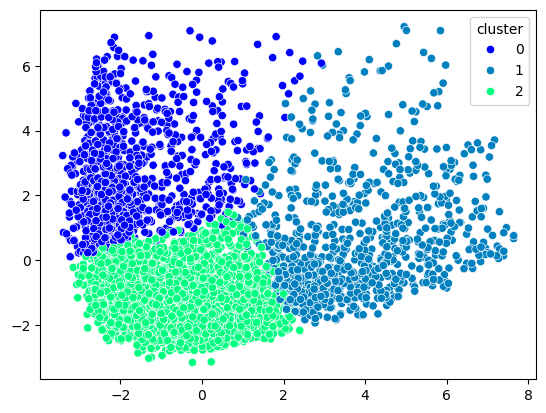

In [43]:

pca_2d = PCA(n_components=5)
pca_2d.fit(data_fe)

sales_scaled_pca_2d = pca_2d.fit_transform(data_fe)

sns.scatterplot(x=sales_scaled_pca_2d[:,0], y=sales_scaled_pca_2d[:,1], hue=data['cluster'], palette='winter',)

Dari Hasil visualisasi diatas, diketahui : 
- Terlihat ada pemisahan yang cukup jelas antara cluster 1 dan 2. Namun, antara cluster 1 dan 0, pemisahannya mungkin tidak sejelas antara 1 dan 2.
- Cluster 0 memiliki kepadatan yang lebih tinggi dibandingkan dua cluster lainnya. Ini menunjukkan bahwa data dalam cluster 0 memiliki karakteristik yang lebih konsisten.

## Karakteristik Masing-masing segment

### Payments vs Purchases

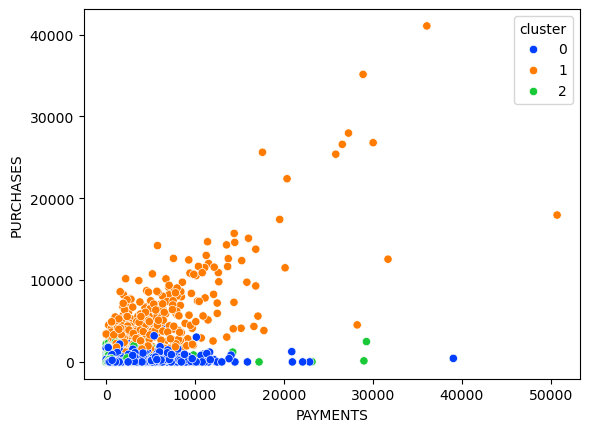

In [44]:
sns.scatterplot(data=data, x="PAYMENTS", y="PURCHASES", hue="cluster",palette="bright");

- Cluster 0 (Biru): Pelanggan di cluster ini cenderung melakukan pembelian dan pembayaran dalam jumlah yang relatif rendah hingga sedang.
- Cluster 1 (Oranye): Pelanggan di cluster ini cenderung melakukan pembelian dan pembayaran dalam jumlah yang lebih tinggi dibandingkan dengan cluster 0.
- Cluster 2 (Hijau): Pelanggan di cluster ini merupakan kelompok yang paling sedikit dan cenderung melakukan pembelian dan pembayaran dalam jumlah yang sangat tinggi.

### PURCHASES TRX VS CASH ADVANCE

<Axes: xlabel='PURCHASES_TRX', ylabel='CASH_ADVANCE'>

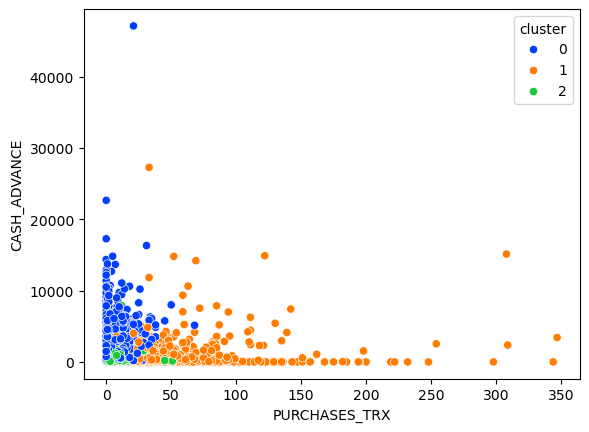

In [45]:
sns.scatterplot(data=data, x="PURCHASES_TRX", y="CASH_ADVANCE", hue="cluster",palette="bright")

- Cluster 0 (Biru): Pelanggan berada di cluster ini cenderung melakukan banyak transaksi pembelian tetapi jarang mengambil uang tunai.
- Cluster 1 (Oranye): Pelanggan di cluster ini cenderung melakukan jumlah transaksi pembelian yang lebih sedikit dibandingkan dengan cluster 0, namun sering mengambil uang tunai.
- Cluster 2 (Hijau): Pelanggan di cluster ini merupakan kelompok yang paling sedikit dan cenderung jarang melakukan transaksi pembelian maupun mengambil uang tunai.

### BALANCE VS CREDIT LIMIT

<Axes: xlabel='BALANCE', ylabel='CREDIT_LIMIT'>

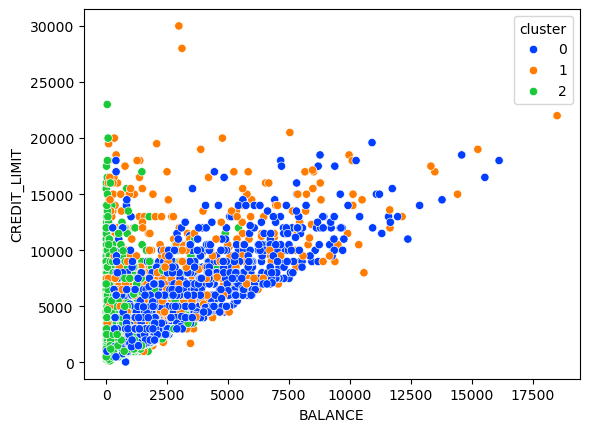

In [46]:
sns.scatterplot(data=data, x="BALANCE", y="CREDIT_LIMIT", hue="cluster",palette="bright")

- Cluster 0 (Biru): Mayoritas pelanggan dengan saldo bervariasi dan limit kredit tinggi, menunjukkan pemanfaatan kredit yang optimal.

- Cluster 1 (Oranye): Pelanggan dengan saldo dan limit kredit lebih rendah, cenderung konservatif dalam penggunaan kredit.

- Cluster 2 (Hijau): Pelanggan paling sedikit dengan saldo dan limit kredit rendah, kemungkinan merupakan pengguna baru atau kurang aktif.

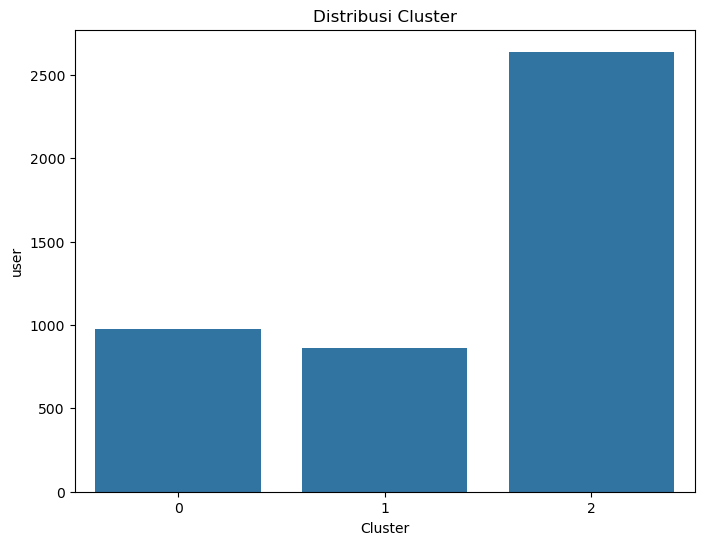

In [47]:
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=data)
plt.title('Distribusi Cluster')
plt.xlabel('Cluster')
plt.ylabel('user')
plt.show()

Dari Visualisasi diatas dapat dilihat, kebanyakan pelanggan berada pada cluster 2 

In [48]:
cluster_summary = data.groupby('cluster').mean()
cluster_summary

CUST_ID      BALANCE  BALANCE_FREQUENCY    PURCHASES  \
cluster                                                             
0        4383.012308  3580.233809           0.951709   268.351221   
1        4435.055749  2063.652320           0.976416  3633.567666   
2        4522.017810   654.722611           0.816850   416.599303   

         ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
cluster                                                           
0              165.745426              102.641405   3314.071578   
1             2284.803600             1349.460929    601.461055   
2              204.599310              212.147397    248.432559   

         PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
cluster                                                    
0                   0.211405                    0.094552   
1                   0.925062                    0.580911   
2                   0.451968                    0.118585   

         PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
cluster                                                             
0                                0.129824                0.405791   
1                                0.718725                0.074594   
2                                0.334592                0.056582   

         CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  \
cluster                                                               
0               10.925128       4.404103   6064.534577  2515.368910   
1                1.943089      49.243902   6803.019744  3727.758087   
2                0.927624       7.622205   3161.902484   805.135714   

         MINIMUM_PAYMENTS  PRC_FULL_PAYMENT     TENURE  
cluster                                                 
0             1548.179479          0.025576  11.392821  
1             1307.860270          0.266215  11.888502  
2              465.105370          0.158432  11.443729

- Cluster 0 (Biru) terdiri dari pelanggan dengan saldo rata-rata yang tinggi (4426.32) dan limit kredit yang lebih tinggi (6769.54), menunjukkan kemampuan mereka untuk menggunakan kredit dengan lebih leluasa. 

- Cluster 1 (Oranye) mencakup pelanggan yang memiliki saldo (4378.12) dan limit kredit (6239.58) yang lebih rendah dibandingkan cluster 0, menunjukkan bahwa mereka menggunakan kredit secara lebih konservatif. 

- Cluster 2 (Hijau) adalah kelompok dengan saldo (4522.70) dan limit kredit terendah (3194.35), mencerminkan status mereka sebagai pengguna baru atau kurang aktif. 

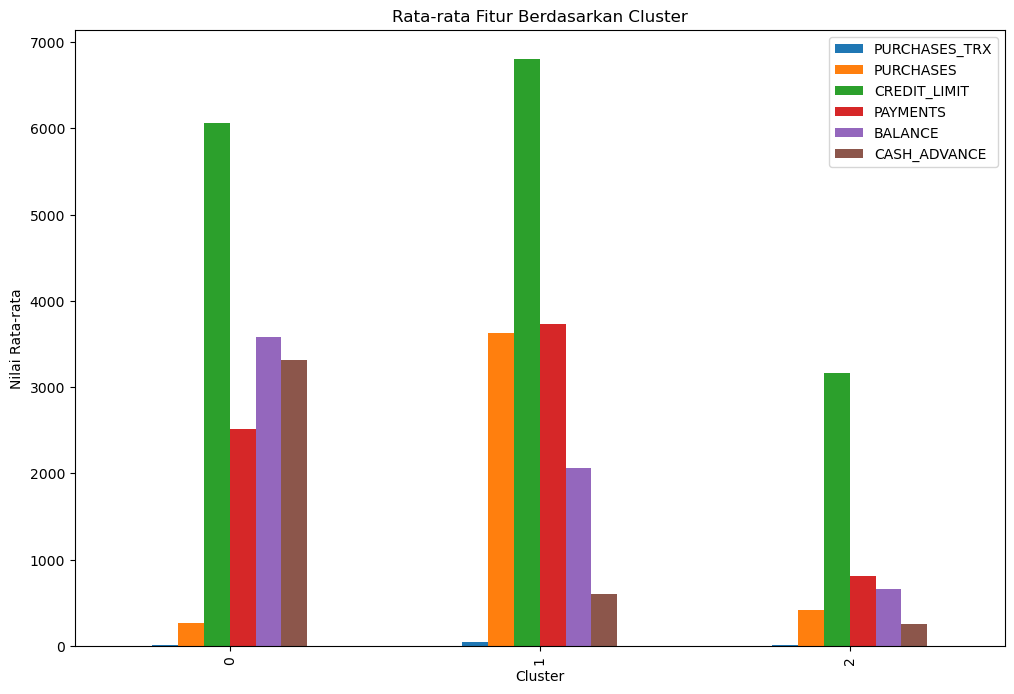

In [49]:
features = ['PURCHASES_TRX', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS','BALANCE','CASH_ADVANCE']
cluster_summary[features].plot(kind='bar', figsize=(12, 8))
plt.title('Rata-rata Fitur Berdasarkan Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nilai Rata-rata')
plt.show()

**Cluster 0:**   
Pelanggan dalam cluster 0 dapat dikategorikan sebagai pelanggan yang aktif menggunakan kartu kredit mereka untuk transaksi pembelian.

**Cluster 1:**   
Pelanggan dalam cluster 1 dapat dikategorikan sebagai pengguna kartu kredit yang lebih moderat. Mereka melakukan transaksi pembelian dan pembayaran dalam jumlah yang lebih sedikit dibandingkan dengan cluster 0.

**Cluster 2:**  
Pelanggan dalam cluster 2 memiliki perilaku yang berada di antara cluster 0 dan 1. Mereka melakukan transaksi pembelian dalam jumlah yang sedang, namun cenderung lebih sering mengambil uang tunai dibandingkan dengan cluster 0.

# Model Saving

In [50]:
#Save Files

with open('list_num_col.txt', 'w') as file_1:
  json.dump(num_cols, file_1)

with open('scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('pca.pkl', 'wb') as file_3:
  pickle.dump(pca, file_3)

with open('kmeans.pkl', 'wb') as file_4:
  pickle.dump(km, file_4)

# Kesimpulan

Dalam upaya memahami perilaku penggunaan kredit pelanggan, kami telah melakukan segmentasi berdasarkan data penggunaan kartu kredit .

Hasil analisis ini mengungkap tiga kelompok pelanggan dengan karakteristik dan pola transaksi yang berbeda. Setiap cluster mencerminkan kebutuhan dan perilaku unik, yang memberikan kesempatan bagi tim pemasaran untuk merancang strategi yang lebih tepat sasaran. 

Berikut adalah deskripsi lengkap dari masing-masing cluster beserta rekomendasi yang dapat diimplementasikan.

**Cluster 0** 
- Nama: "Pengguna Proaktif"
- Alasan: Pelanggan di cluster ini menunjukkan pemanfaatan kredit yang optimal dan aktif dalam melakukan transaksi, serta memiliki saldo dan limit kredit yang tinggi.
-Rekomendasi : Fokus pada upaya penagihan dan pengelolaan risiko kredit. Tawarkan program cicilan atau restrukturisasi utang untuk membantu pelanggan melunasi tagihan.


**Cluster 1**
- Nama: "Pengguna Konservatif"
- Alasan: Pelanggan di cluster ini memiliki saldo dan limit kredit yang lebih rendah, dengan perilaku yang cenderung hati-hati dalam menggunakan kredit.
- Rekomendasi : 
Fokus pada upaya penagihan dan pengelolaan risiko kredit. Tawarkan program cicilan atau restrukturisasi utang untuk membantu pelanggan melunasi tagihan.

**Cluster 2** 
- Nama: "Pengguna Pasif"
- Alasan: Pelanggan di cluster ini memiliki saldo dan limit kredit yang terendah, serta aktivitas yang rendah dalam penggunaan kredit, menunjukkan kemungkinan mereka adalah pengguna baru atau kurang aktif.
- Rekomendasi : Tawarkan promo atau diskon khusus, serta kembangkan produk atau layanan yang sesuai dengan anggaran mereka.